# Exploratory Data Analysis and Feature Engineering for Supervised ML

## Data Preparation

Generating a MapInfo File with hexagons and their stats.

Use the custom geometry which splits the hexagons along city borders
and subsequently merges small and medium (PCCLASS 2,3) cities into single 
areas. (Which is a file output from elsewhere, technically could be computed
here as well). 

It combines the above against tiles from the Ookla dataset. This 
is done by calculating the spatial join (GeoPandas sjoin()) on the 
default "intersection" predicate. This allows some tiles 
to contribute to multiple hexagons if they partially overlap more 
than one area.

For many (rural) areas there are no or few tiles from this; so an expanding 
selection is done to try and get better stats in these areas by 
verifying the sum of tests in the area are at least 10, 
adding first the remainder of the "fixed" data tiles for 
earlier quarter, then all tiles tiles (including mobile tiles)
if that still does not give at least 10 tests. 

In [ ]:
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload 1
%aimport src.datasets.joins
%aimport src.datasets.loading.statcan

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from src.datasets.loading import statcan
from src.datasets.loading import ookla
from src.datasets import overlays

import statsmodels as sm
# import statsmodels.stats.weightstats
from scipy.stats import lognorm

import src.config
from pathlib import Path
import geopandas as gp
import src.datasets.joins as joins

import re

In [ ]:
# Defining output directory
output_name = "BestEstimate_On_DissolvedSmallerCitiesHexes_Time"
output_dir = src.config.DATA_DIRECTORY / "processed" / "statistical_geometries" / "time"
output_dir.mkdir(exist_ok=True)

In [ ]:
CRS = 'EPSG:4326'

In [ ]:
# statscan data
popctrs = statcan.boundary('population_centres')
derived_geometry = (Path(src.config.DATA_DIRECTORY) / 'processed' / 'geometries').resolve()

statscan_data = gp.read_file(derived_geometry / 'hexagons_w_dissolved_smaller_popctrs.geojson')
statscan_data = statscan_data.dropna(subset=['HEXUID_PCPUID'])
statscan_data.head()

In [ ]:
def year_serializeable(tuple_or_na):
    if pd.isna(tuple_or_na):
        return "No Data"
    return "Q{1} {0}".format(*tuple_or_na)

def connections_serializeable(set_):
    if set_ == {'fixed'}:
        return 'fixed'
    elif set_ == {'fixed','mobile'}:
        return 'fixed and mobile'
    elif set_ == {'mobile'}:
        return 'mobile'
    else:
        return 'No Data'


pat = '(\d\d)p_*'
t = '25p_d_kbps'
fix_bad_names = lambda x: re.sub(pat, lambda s:f'P{s.group(1)}_', x)

In [ ]:
def get_quaterly_data(year, quarter):
    speed_data = statscan_data.copy()
    print("Grabbing statscan speed data")
    
    # getting the tile data (Q1)
    print("Getting ookla tiles")
    
    tiles = ookla.canada_speed_tiles().loc[lambda s:(s.year==year) & (s.quarter==quarter) & (s.conn_type=='fixed')]
    
    unique_tiles = tiles[['quadkey','geometry']].drop_duplicates()
    unique_tiles = unique_tiles.sjoin(speed_data[['HEXUID_PCPUID','geometry']].to_crs(tiles.crs))
    unique_tiles = unique_tiles.drop(['index_right'],axis=1)
    
    tiles = tiles.merge(unique_tiles.drop(['geometry'],axis=1), on='quadkey')
    
    # creating the quaterly datasets 
    print("Cleaning ookla data")
    tests_in_q1_quarters = tiles.loc[lambda s:((s.year==2019) & (s.quarter==1))].loc[lambda s:s.conn_type=='fixed'].groupby('HEXUID_PCPUID')['tests'].sum()
    
    level_1_areas = tests_in_q1_quarters.index[tests_in_q1_quarters > 10].dropna()
    
    fixed_tests_counts_nolevel1 = tiles.loc[lambda s:~s.HEXUID_PCPUID.isin(level_1_areas)].loc[lambda s:s.conn_type == 'fixed'].groupby('HEXUID_PCPUID')['tests'].sum()
    
    level_2_areas = fixed_tests_counts_nolevel1.index[fixed_tests_counts_nolevel1 > 10].dropna()
    
    level_3_areas = tiles.drop_duplicates(subset='HEXUID_PCPUID').loc[lambda s:~s.HEXUID_PCPUID.isin(level_1_areas) & ~s.HEXUID_PCPUID.isin(level_2_areas)].HEXUID_PCPUID.dropna().values
    
    l1_tiles = tiles.loc[lambda s:s.HEXUID_PCPUID.isin(level_1_areas)].loc[lambda s:s.conn_type=='fixed']
    l2_tiles = tiles.loc[lambda s:s.HEXUID_PCPUID.isin(level_2_areas)].loc[lambda s:s.conn_type=='fixed']
    l3_tiles = tiles.loc[lambda s:s.HEXUID_PCPUID.isin(level_3_areas)]
    selected_tiles = pd.concat([l1_tiles, l2_tiles, l3_tiles]).drop_duplicates(subset=['quadkey','conn_type','year','quarter'])
    
    # aggregating the data
    print("Aggregating the data")
    speed_data = joins.add_simple_stats(speed_data, selected_tiles, 'HEXUID_PCPUID')
    
    speed_data = joins.add_50_10_stats(speed_data, selected_tiles, 'HEXUID_PCPUID')
    
    unused_columns = ['pc_area','hex_area','pc_frac', 'hex_frac']
    for col in unused_columns:
        del speed_data[col]
    
    speed_data['ookla_50_10_percentile'] = speed_data.apply(lambda s:min(s['50_down_percentile'], s['10_up_percentile']), axis=1)
    
    speed_data = joins.add_tile_info(speed_data, selected_tiles, "HEXUID_PCPUID")

    speed_data['min_year'] = speed_data['min_year'].apply(year_serializeable)
    speed_data['max_year'] = speed_data['max_year'].apply(year_serializeable)
    speed_data['connections'] = speed_data['connections'].apply(connections_serializeable)
    
    speed_data.rename(columns=fix_bad_names, inplace=True)
    speed_data.rename(columns={'50_down_percentile':'Down_50_percentile', '10_up_percentile':'Up_10_percentile'}, inplace=True)
    
    speed_data.rename(columns=fix_bad_names, inplace=True)
    speed_data.rename(columns={'50_down_percentile':'Down_50_percentile', '10_up_percentile':'Up_10_percentile'}, inplace=True)
    
    # removing extra data and cleaning up
    print("Cleaning aggregated dataframe")
    speed_data = speed_data[speed_data.min_year != 'No Data']
    speed_data['year'] = str(year)
    speed_data['quarter'] = str(quarter)
    speed_data.drop(columns=['min_year', 'max_year'], axis=1, inplace=True)
    
    # saving the geoframe
    print("Saving aggregated dataframe")
    speed_data.crs
    speed_data.loc[lambda s:(s.Pop2016 > 0.0) | (s.tests > 0.0)].to_file(output_dir / (output_name+"_"+str(year)+"_"+str(quarter)), driver="MapInfo File")
    speed_data.loc[lambda s:(s.Pop2016 > 0.0) | (s.tests > 0.0)].to_file(output_dir / (output_name+"_"+str(year)+"_"+str(quarter)+".gpkg"), driver="GPKG")
    
    print("DataFrame saved succesfully")

### Generating and saving the GeoDataFrames

In [ ]:
get_quaterly_data(2019, 1)

In [ ]:
get_quaterly_data(2019, 2)

In [ ]:
get_quaterly_data(2019, 3)

In [ ]:
get_quaterly_data(2019, 4)

In [ ]:
get_quaterly_data(2020, 1)

In [ ]:
get_quaterly_data(2020, 2)

In [ ]:
get_quaterly_data(2020, 3)

In [ ]:
get_quaterly_data(2020, 4)

In [ ]:
get_quaterly_data(2021, 1)

In [ ]:
get_quaterly_data(2021, 2)

In [ ]:
get_quaterly_data(2021, 3)

In [ ]:
get_quaterly_data(2021, 4)

In [ ]:
get_quaterly_data(2022, 1)

In [ ]:
get_quaterly_data(2022, 2)

In [ ]:
get_quaterly_data(2022, 3)

In [ ]:
get_quaterly_data(2022, 4)

In [ ]:
get_quaterly_data(2023, 1)

### Concatenating the GeoDataFrames

In [ ]:
# define data directory
data_dir = src.config.DATA_DIRECTORY / "processed" / "statistical_geometries"

# load data without regenerating the geodataframe 
data_name = "BestEstimate_On_DissolvedSmallerCitiesHexes_Time_2019_1"
data_2019_1 = gp.read_file(data_dir / (data_name+".gpkg"), driver="GPKG")

data_name = "BestEstimate_On_DissolvedSmallerCitiesHexes_Time_2019_2"
data_2019_2 = gp.read_file(data_dir / (data_name+".gpkg"), driver="GPKG")

data_name = "BestEstimate_On_DissolvedSmallerCitiesHexes_Time_2019_3"
data_2019_3 = gp.read_file(data_dir / (data_name+".gpkg"), driver="GPKG")

data_name = "BestEstimate_On_DissolvedSmallerCitiesHexes_Time_2019_4"
data_2019_4 = gp.read_file(data_dir / (data_name+".gpkg"), driver="GPKG")

data_name = "BestEstimate_On_DissolvedSmallerCitiesHexes_Time_2020_1"
data_2020_1 = gp.read_file(data_dir / (data_name+".gpkg"), driver="GPKG")

data_name = "BestEstimate_On_DissolvedSmallerCitiesHexes_Time_2020_2"
data_2020_2 = gp.read_file(data_dir / (data_name+".gpkg"), driver="GPKG")

data_name = "BestEstimate_On_DissolvedSmallerCitiesHexes_Time_2020_3"
data_2020_3 = gp.read_file(data_dir / (data_name+".gpkg"), driver="GPKG")

data_name = "BestEstimate_On_DissolvedSmallerCitiesHexes_Time_2020_4"
data_2020_4 = gp.read_file(data_dir / (data_name+".gpkg"), driver="GPKG")

data_name = "BestEstimate_On_DissolvedSmallerCitiesHexes_Time_2021_1"
data_2021_1 = gp.read_file(data_dir / (data_name+".gpkg"), driver="GPKG")

data_name = "BestEstimate_On_DissolvedSmallerCitiesHexes_Time_2021_2"
data_2021_2 = gp.read_file(data_dir / (data_name+".gpkg"), driver="GPKG")

data_name = "BestEstimate_On_DissolvedSmallerCitiesHexes_Time_2021_3"
data_2021_3 = gp.read_file(data_dir / (data_name+".gpkg"), driver="GPKG")

data_name = "BestEstimate_On_DissolvedSmallerCitiesHexes_Time_2021_4"
data_2021_4 = gp.read_file(data_dir / (data_name+".gpkg"), driver="GPKG")

data_name = "BestEstimate_On_DissolvedSmallerCitiesHexes_Time_2022_1"
data_2022_1 = gp.read_file(data_dir / (data_name+".gpkg"), driver="GPKG")

data_name = "BestEstimate_On_DissolvedSmallerCitiesHexes_Time_2022_2"
data_2022_2 = gp.read_file(data_dir / (data_name+".gpkg"), driver="GPKG")

data_name = "BestEstimate_On_DissolvedSmallerCitiesHexes_Time_2022_3"
data_2022_3 = gp.read_file(data_dir / (data_name+".gpkg"), driver="GPKG")

data_name = "BestEstimate_On_DissolvedSmallerCitiesHexes_Time_2022_4"
data_2022_4 = gp.read_file(data_dir / (data_name+".gpkg"), driver="GPKG")

data_name = "BestEstimate_On_DissolvedSmallerCitiesHexes_Time_2023_1"
data_2023_1 = gp.read_file(data_dir / (data_name+".gpkg"), driver="GPKG")

data = pd.concat([data_2019_1, data_2019_2, data_2019_3, data_2019_4,
                  data_2020_1, data_2020_2, data_2020_3, data_2020_4,
                  data_2021_1, data_2021_2, data_2021_3, data_2021_4, 
                  data_2022_1, data_2022_2, data_2022_3, data_2022_4,
                  data_2023_1])

# saving the concatenated data file 
data.crs
data.to_file(output_dir / output_name, driver="MapInfo File")
data.to_file(output_dir / (output_name+".gpkg"), driver="GPKG")

In [ ]:
data.head()

## Exploratory Data Analysis

In [1]:
import src.config

# data analysis and visualization 
import numpy as np
import pandas as pd
import geopandas as gp
import seaborn as sns
import matplotlib.pyplot as plt 

# modeling packages
import statsmodels as sm
from sklearn import preprocessing, pipeline, compose
from sklearn import linear_model, model_selection, svm
from sklearn import metrics

In [2]:
# customize dataframe view
pd.set_option('display.max_columns', None)

In [3]:
# define data directory
data_name = "BestEstimate_On_DissolvedSmallerCitiesHexes_Time"
data_dir = src.config.DATA_DIRECTORY / "processed" / "statistical_geometries" / "time"

# load data without regenerating the geodataframe 
data = gp.read_file(data_dir / (data_name+".gpkg"), driver="GPKG")
data.head()

,PCPUID,HEXUID_PCPUID,PRCODE,PCNAME,PCCLASS,Pop2016,TDwell2016_TLog2016,URDwell2016_RH2016,PHH_Count,Common_Type,Pop2016_at_50_10_Combined,TDwell2016_at_50_10_Combined,URDwell_at_50_10_Combined,Pop_Avail_50_10,TDwell_Avail_50_10,URDwell_Avail_50_10,avg_d_kbps,std_d_kbps,min_d_kbps,P25_d_kbps,P50_d_kbps,P75_d_kbps,max_d_kbps,avg_u_kbps,std_u_kbps,min_u_kbps,P25_u_kbps,P50_u_kbps,P75_u_kbps,max_u_kbps,avg_lat_ms,tests,ave_tests_per_tile,unique_devices,ave_devices_per_tile,num_tiles,Down_50_percentile,Up_10_percentile,ookla_50_10_percentile,connections,year,quarter,geometry
0,100792,NL47580528-100792,NL,St. John's,4,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,102684.125000,73606.566105,1778.0,45086.0,87998.5,145457.75,323175.0,71012.583333,73606.566105,4936.0,29483.50,64054.0,98957.0,279398.0,7.166667,540.0,11.250000,206.0,4.291667,48.0,72.916667,89.583333,72.916667,fixed,2019,1,"MULTIPOLYGON (((-52.78788 47.56551, -52.78288 ..."
1,100792,NL47580529-100792,NL,St. John's,4,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,133066.516129,102702.357769,5245.0,59949.0,96491.0,164876.00,373129.0,95761.903226,102702.357769,10411.0,34611.50,81149.0,123212.0,323102.0,7.451613,176.0,5.677419,55.0,1.774194,31.0,74.193548,100.000000,74.193548,fixed,2019,1,"POLYGON ((-52.90996 47.56425, -52.90990 47.564..."
2,100792,NL47430528-100792,NL,St. John's,4,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,37021.000000,NaN,37021.0,37021.0,37021.0,37021.00,37021.0,15747.000000,NaN,15747.0,15747.00,15747.0,15747.0,15747.0,2.000000,2.0,2.000000,1.0,1.000000,1.0,0.000000,100.000000,0.000000,fixed,2019,1,"POLYGON ((-52.76428 47.45587, -52.76436 47.454..."
3,100792,NL47510528-100792,NL,St. John's,4,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,99649.597701,57255.122716,1925.0,62974.5,90180.0,134305.50,331983.0,61114.482759,57255.122716,1210.0,37297.50,54710.0,78092.5,175058.0,12.505747,1056.0,12.137931,321.0,3.689655,87.0,83.908046,95.402299,83.908046,fixed,2019,1,"POLYGON ((-52.79738 47.49030, -52.79781 47.490..."
4,100792,NL47510529-100792,NL,St. John's,4,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,108912.500000,79164.061679,802.0,60862.5,80219.5,138908.75,329793.0,81885.826087,79164.061679,745.0,40480.25,64622.5,103484.0,264576.0,43.782609,263.0,5.717391,91.0,1.978261,46.0,78.260870,93.478261,78.260870,fixed,2019,1,"POLYGON ((-52.91007 47.51346, -52.91014 47.513..."


### Looking for trends, patterns, etc.

#### Distribution analyses

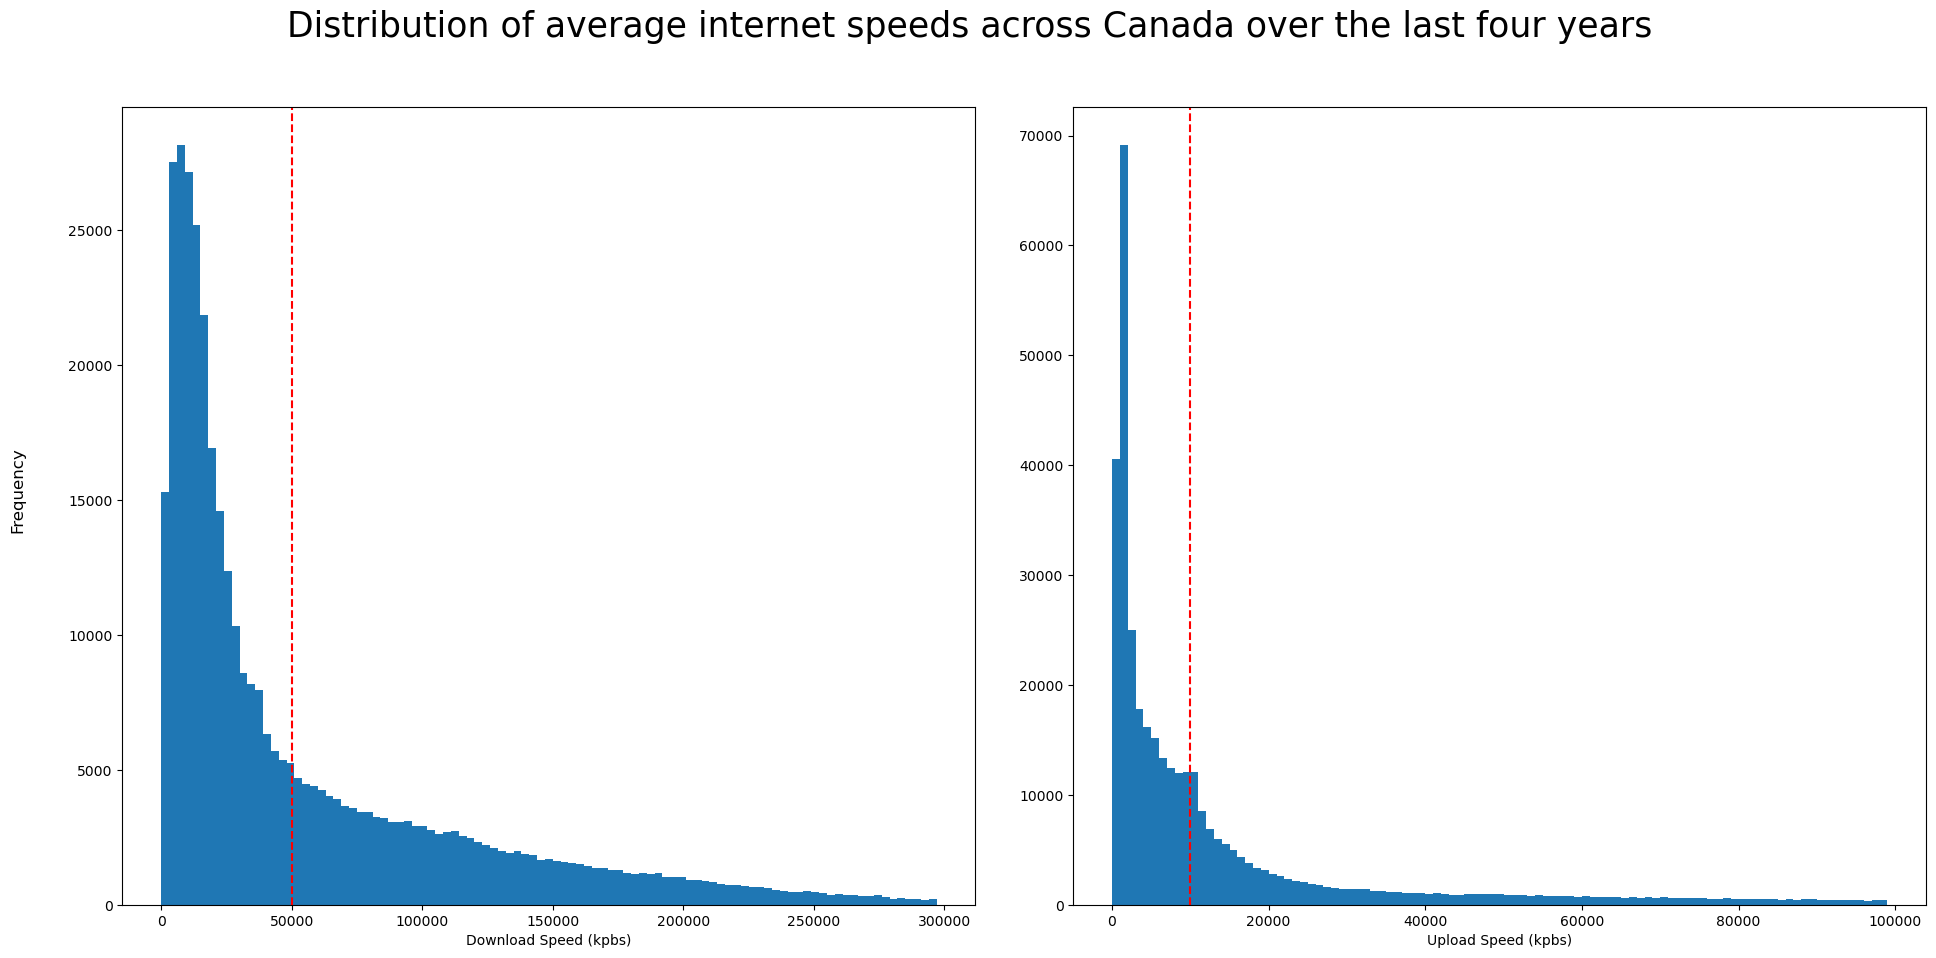

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))

data.hist('avg_d_kbps', bins=range(0,300000,3000), ax=axs[0], grid=False)
data.hist('avg_u_kbps', bins=range(0,100000,1000), ax=axs[1], grid=False)

axs[0].axvline(50000, color='r', ls='--')
axs[1].axvline(10000, color='r', ls='--')

axs[0].set_xlabel('Download Speed (kpbs)')
axs[1].set_xlabel('Upload Speed (kpbs)')

axs[0].set_title('')
axs[1].set_title('')

fig.supylabel('Frequency')
fig.suptitle('Distribution of average internet speeds across ' \
             'Canada over the last four years',
             fontsize=25)
fig.tight_layout(pad=3);

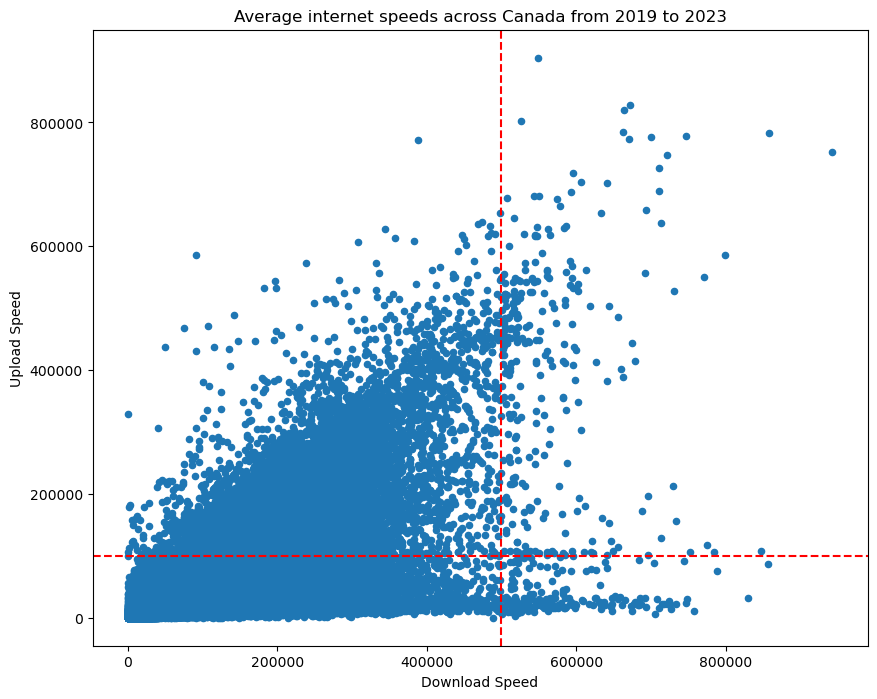

In [5]:
data.plot(x='avg_d_kbps', 
          y='avg_u_kbps',
          kind='scatter', 
          figsize=(10,8),
          grid=False,
          xlabel='Download Speed',
          ylabel='Upload Speed')
plt.gca().axvline(500000,color='r', ls='--')
plt.gca().axhline(100000,color='r', ls='--')
plt.title('Average internet speeds across Canada from 2019 to 2023');

### Location and Internet Speeds

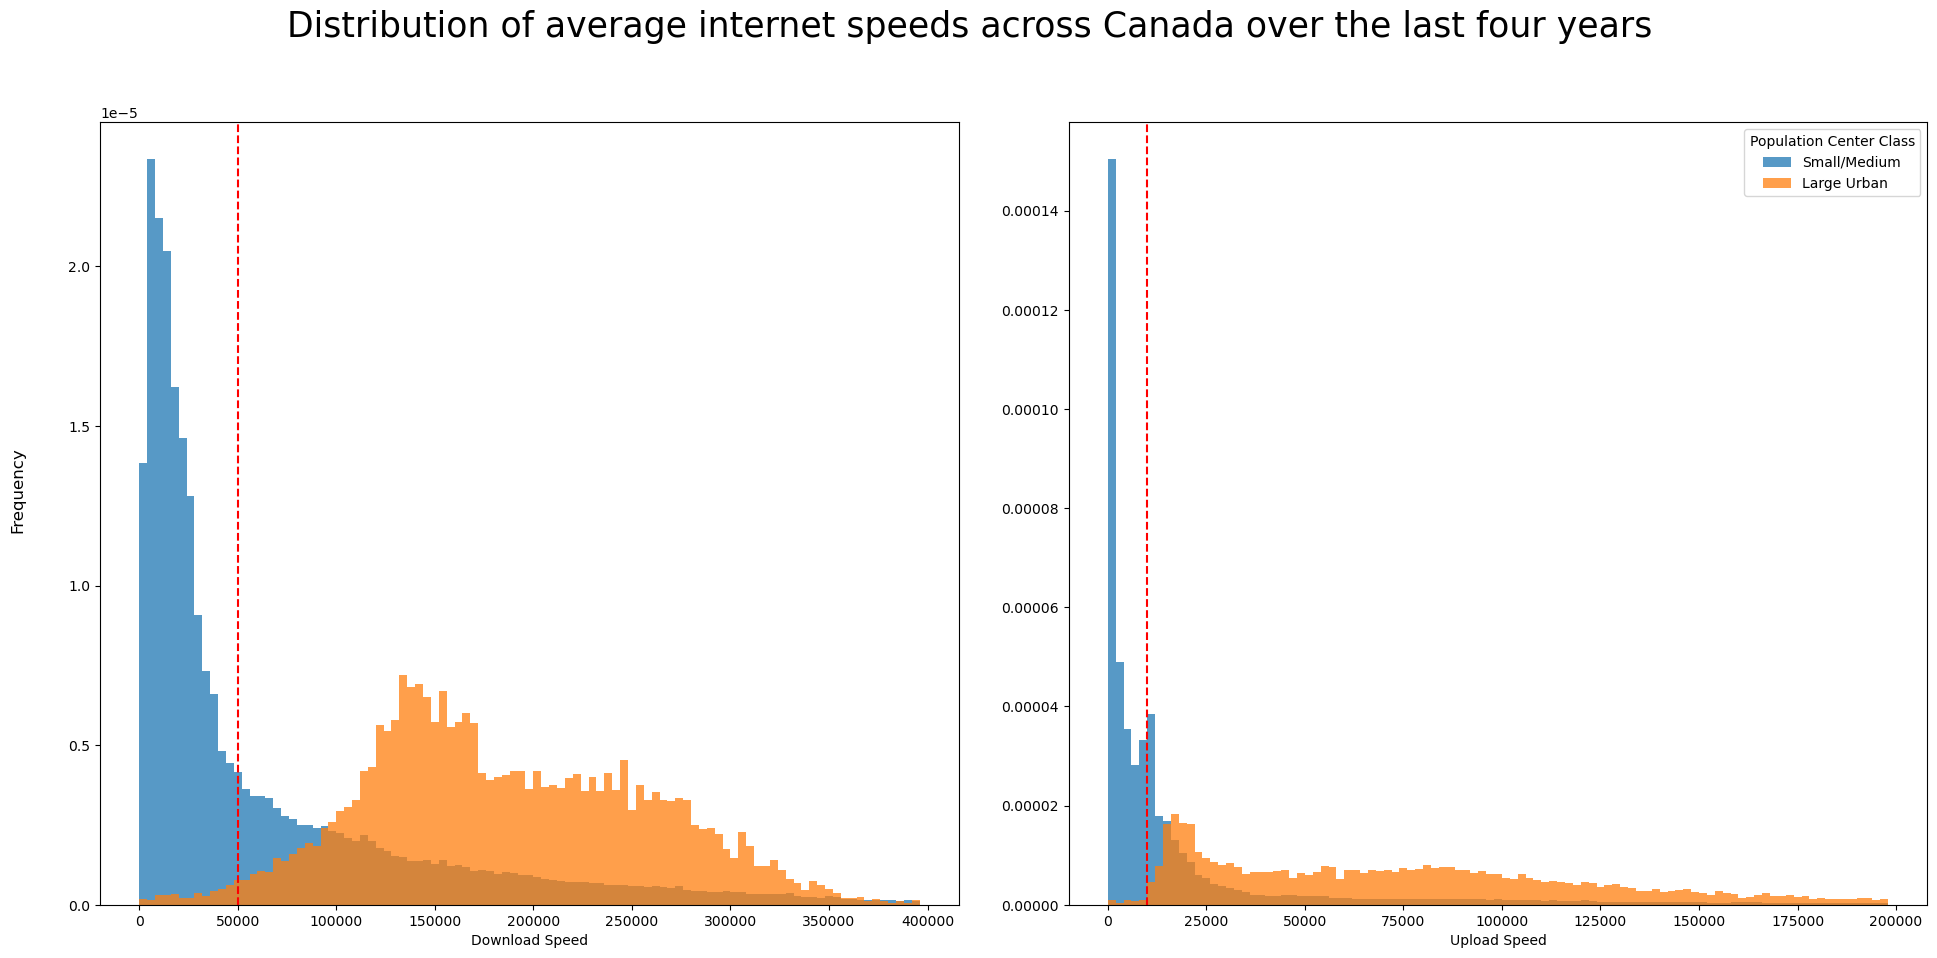

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))

data.loc[lambda s:~(s.PCCLASS == '4')]['P75_d_kbps'].plot.hist(bins=range(0,400000,4000), 
                                                               density=True, alpha=0.75,
                                                               ax=axs[0], grid=False,
                                                               label='Small/Medium')
data.loc[lambda s:(s.PCCLASS == '4')]['P75_d_kbps'].plot.hist(bins=range(0,400000,4000), 
                                                              density=True,alpha=0.75,
                                                              ax=axs[0], grid=False,
                                                               label='Large Urban')


data.loc[lambda s:~(s.PCCLASS == '4')]['P75_u_kbps'].plot.hist(bins=range(0,200000,2000), 
                                                               density=True, alpha=0.75,
                                                               ax=axs[1], grid=False,
                                                               label='Small/Medium')
data.loc[lambda s:(s.PCCLASS == '4')]['P75_u_kbps'].plot.hist(bins=range(0,200000,2000), 
                                                              density=True,alpha=0.75,
                                                              ax=axs[1], grid=False,
                                                               label='Large Urban')

axs[0].axvline(50000, color='r', ls='--')
axs[1].axvline(10000, color='r', ls='--')

axs[0].set_xlabel('Download Speed')
axs[1].set_xlabel('Upload Speed')
axs[0].set_ylabel('')
axs[1].set_ylabel('')

axs[0].set_title('')
axs[1].set_title('')

fig.supylabel('Frequency')
fig.suptitle('Distribution of average internet speeds across ' \
             'Canada over the last four years',
             fontsize=25)
fig.tight_layout(pad=3)
plt.legend(title='Population Center Class');

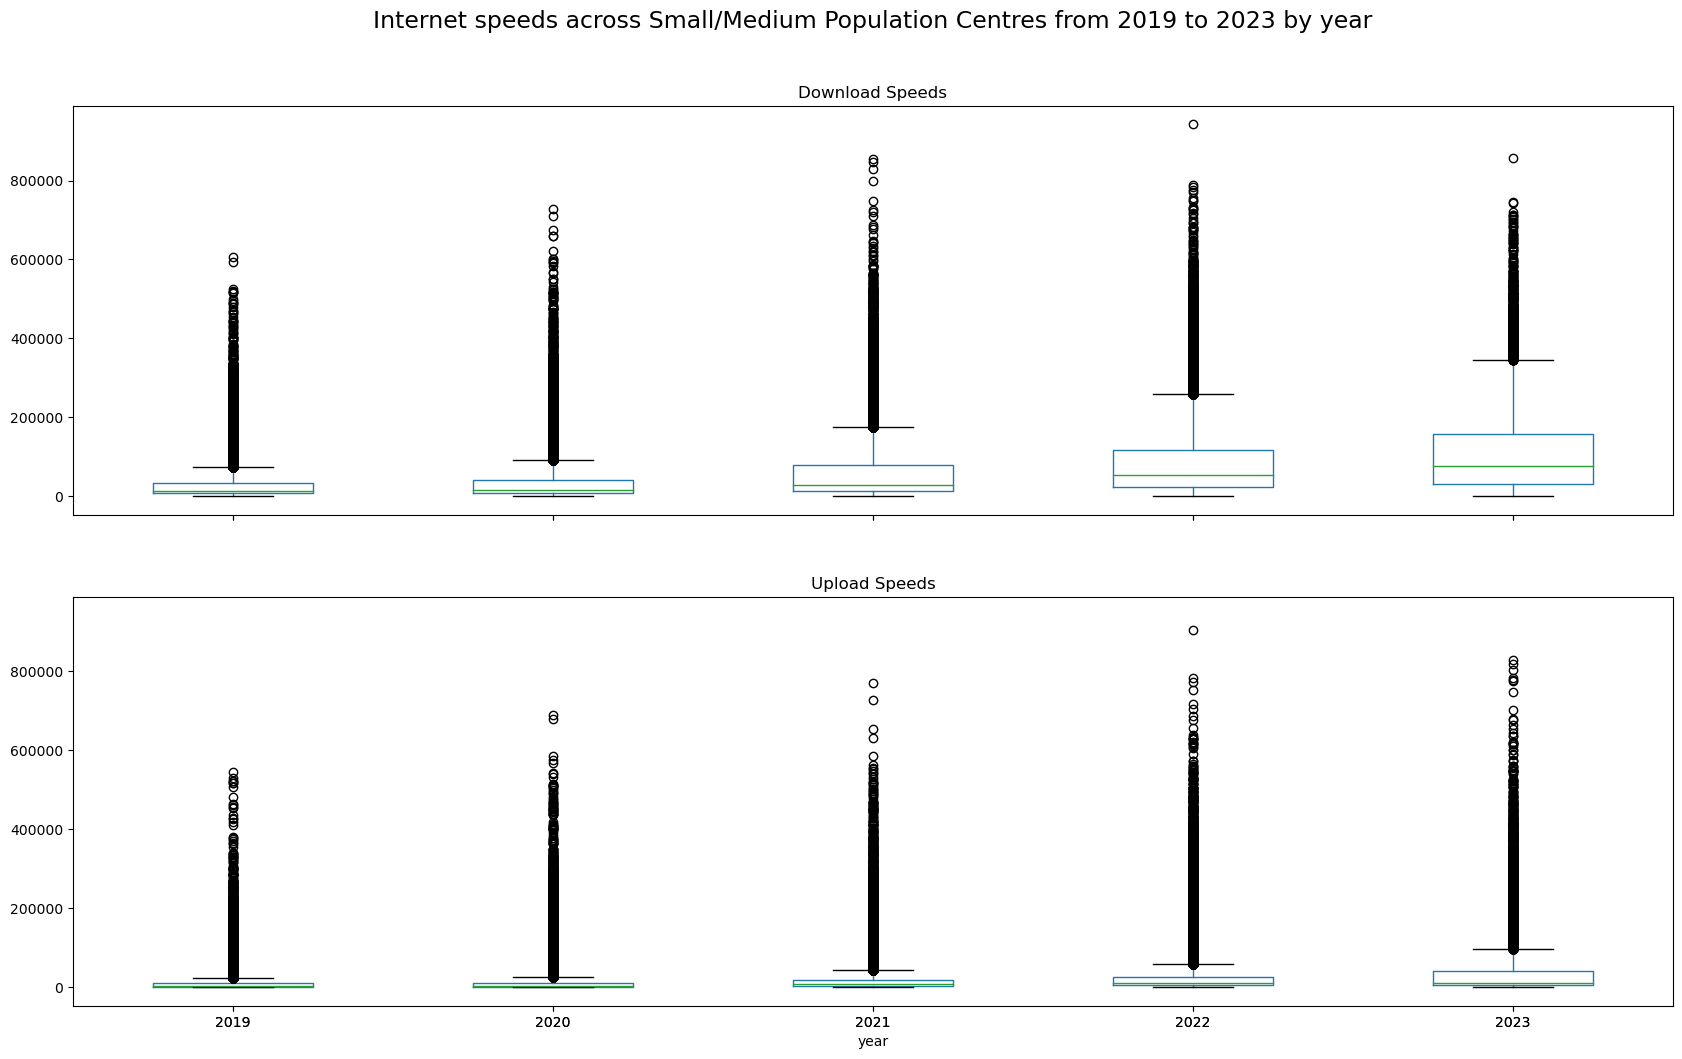

In [7]:
# location vs. internet speed for small/medium regions by year

data_loc = data.loc[lambda s:~(s.PCCLASS == '4')]

ax = data_loc.boxplot(column=['avg_d_kbps', 'avg_u_kbps'], 
                      by='year',
                      grid=False, 
                      figsize=(20,12),
                      layout=(2,1))

ax[0].set_title('Download Speeds')
ax[1].set_title('Upload Speeds')

plt.suptitle('Internet speeds across Small/Medium Population ' \
             'Centres from 2019 to 2023 by year',
             fontsize=17);

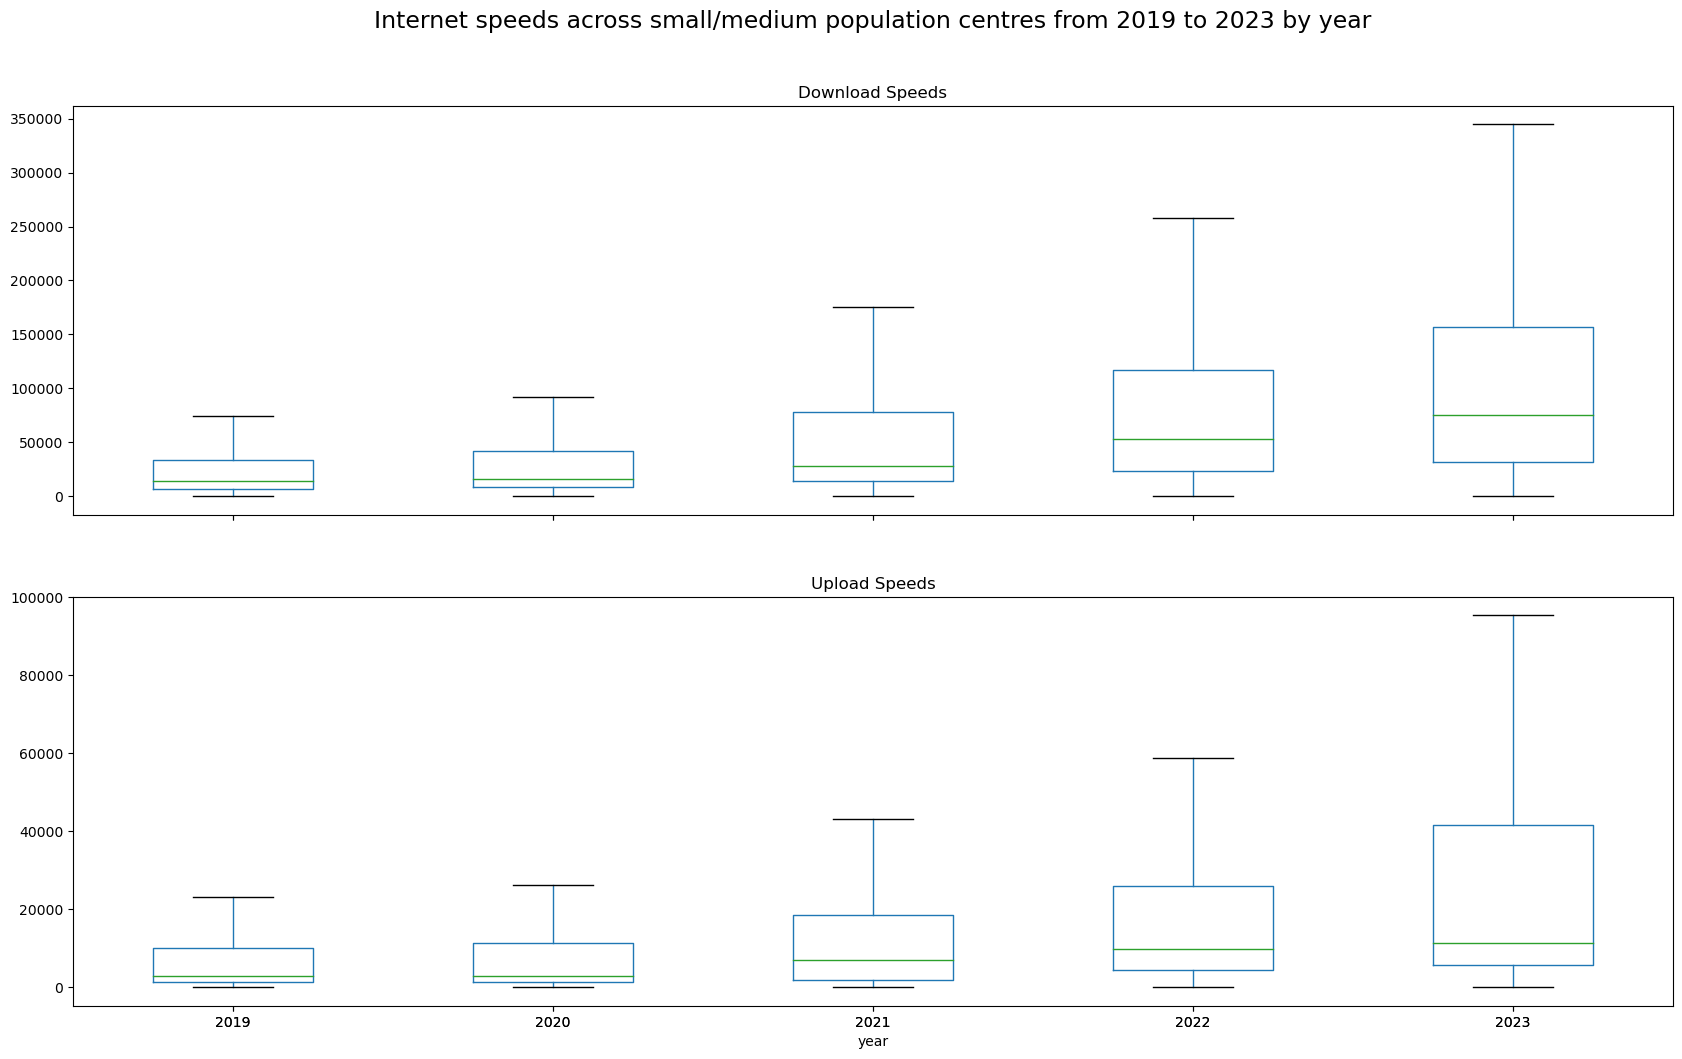

In [8]:
# location vs. internet speed for small/medium regions by year

data_loc = data.loc[lambda s:~(s.PCCLASS == '4')]

ax = data_loc.boxplot(column=['avg_d_kbps', 'avg_u_kbps'], 
                      by='year',
                      grid=False, 
                      figsize=(20,12),
                      layout=(2,1),
                      showfliers=False,
                      sharey=False)

ax[0].set_title('Download Speeds')
ax[1].set_title('Upload Speeds')

plt.suptitle('Internet speeds across small/medium population ' \
             'centres from 2019 to 2023 by year',
             fontsize=17);

#### Internet speeds over time

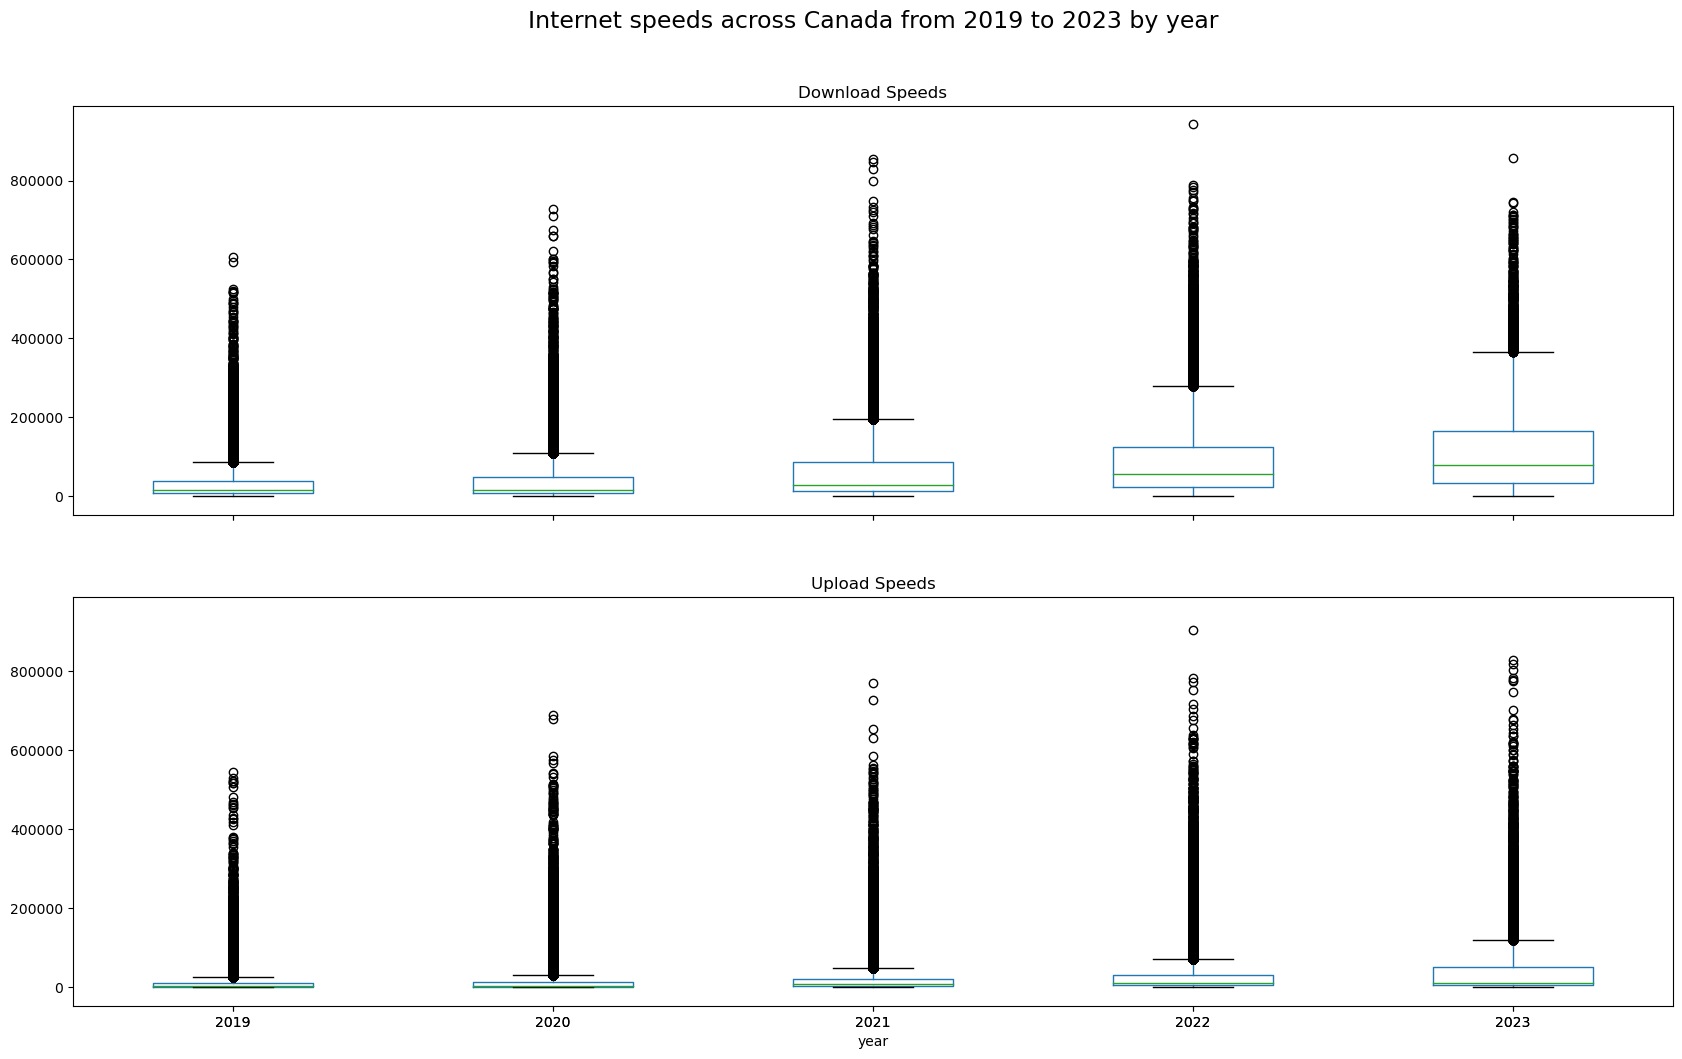

In [9]:
ax = data.boxplot(column=['avg_d_kbps', 'avg_u_kbps'], 
                  by='year',
                  grid=False, 
                  figsize=(20,12),
                  layout=(2,1))

ax[0].set_title('Download Speeds')
ax[1].set_title('Upload Speeds')

plt.suptitle('Internet speeds across Canada from ' \
             '2019 to 2023 by year',
             fontsize=17);

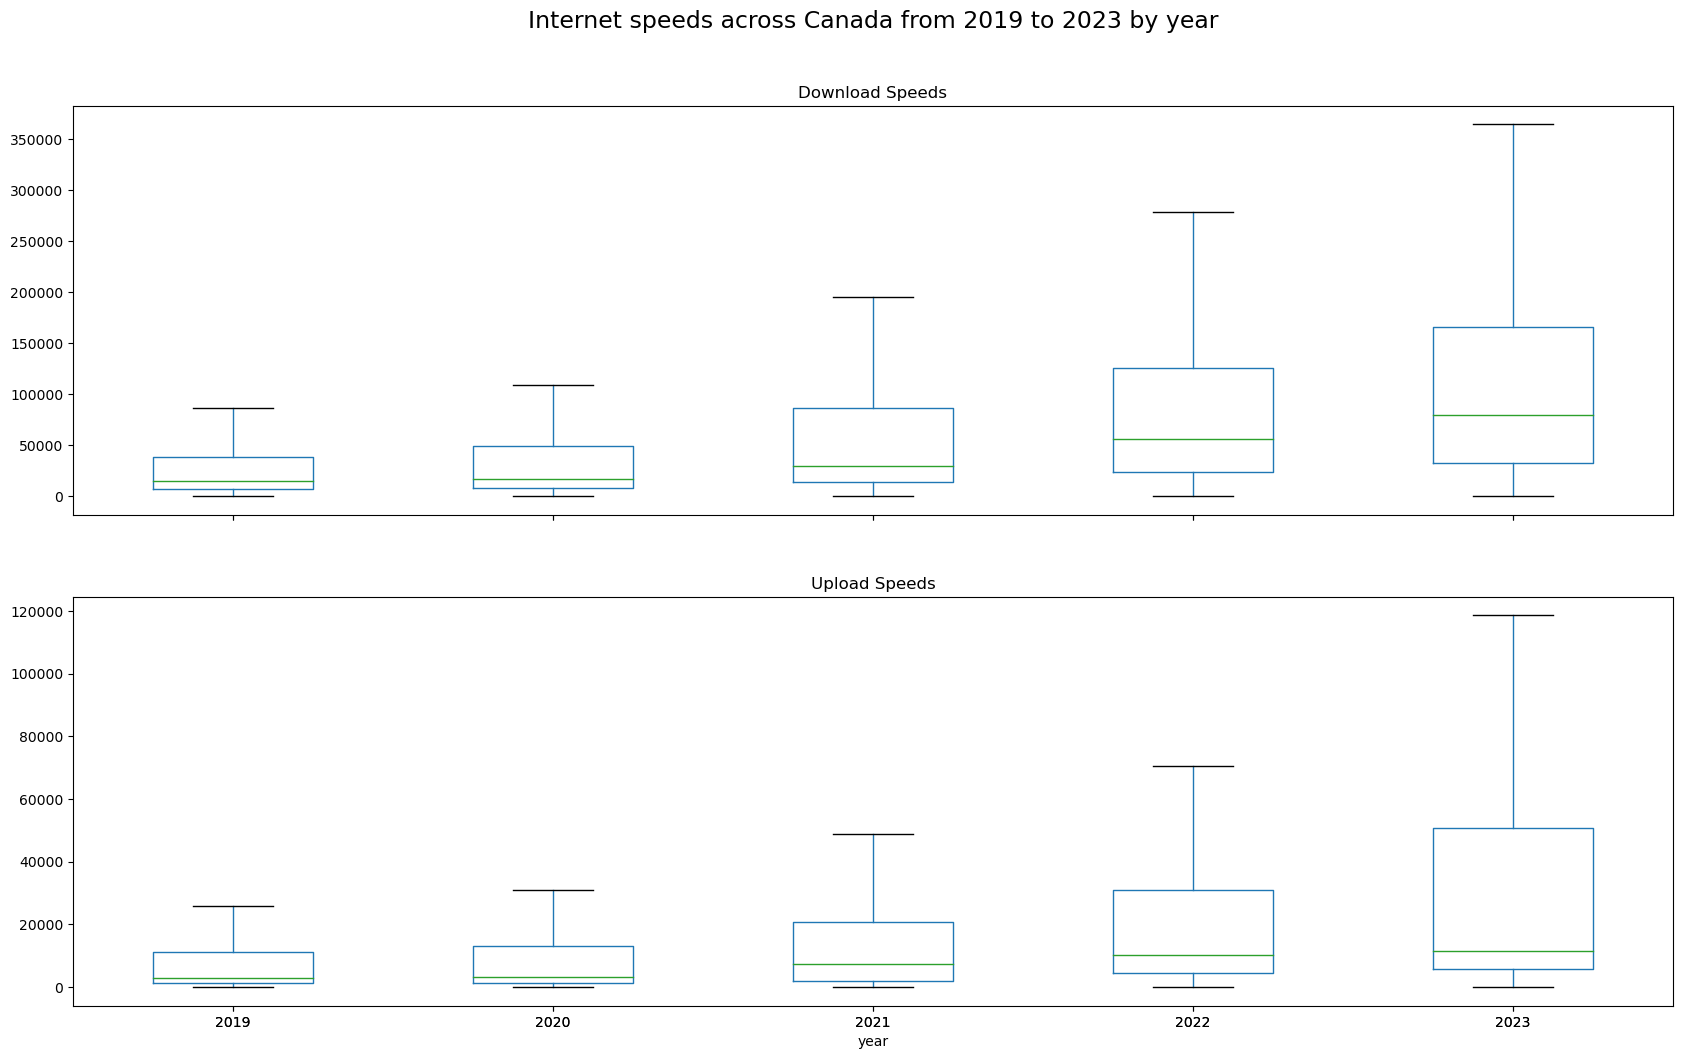

In [10]:
ax = data.boxplot(column=['avg_d_kbps', 'avg_u_kbps'], 
                  by='year',
                  grid=False, 
                  figsize=(20,12),
                  layout=(2,1),
                  showfliers=False,
                  sharey=False)

ax[0].set_title('Download Speeds')
ax[1].set_title('Upload Speeds')

plt.suptitle('Internet speeds across Canada from ' \
             '2019 to 2023 by year',
             fontsize=17);

#### Reported vs. actual speeds in Alberta

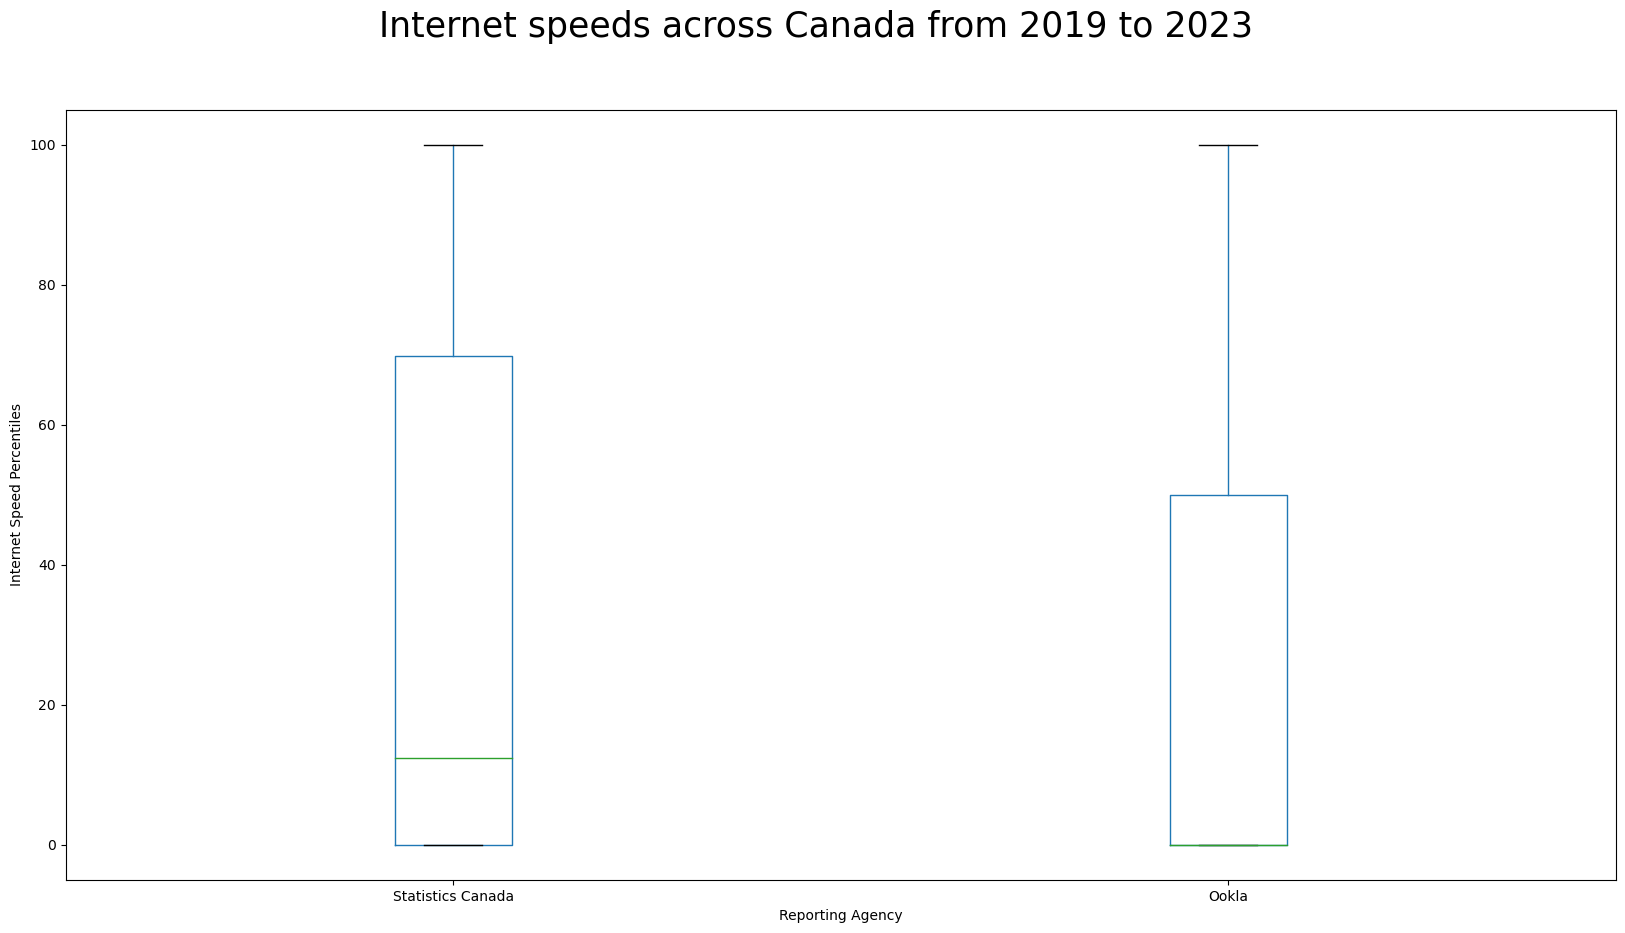

In [11]:
ax = data.boxplot(column=['Pop_Avail_50_10', 
                          'ookla_50_10_percentile'], 
                  grid=False, 
                  figsize=(20,10))
labels = ['Statistics Canada', 'Ookla']

ax.set_xlabel('Reporting Agency')
ax.set_ylabel('Internet Speed Percentiles')
ax.set_xticklabels(labels)


plt.suptitle('Internet speeds across Canada from 2019 to 2023',
             fontsize=25);

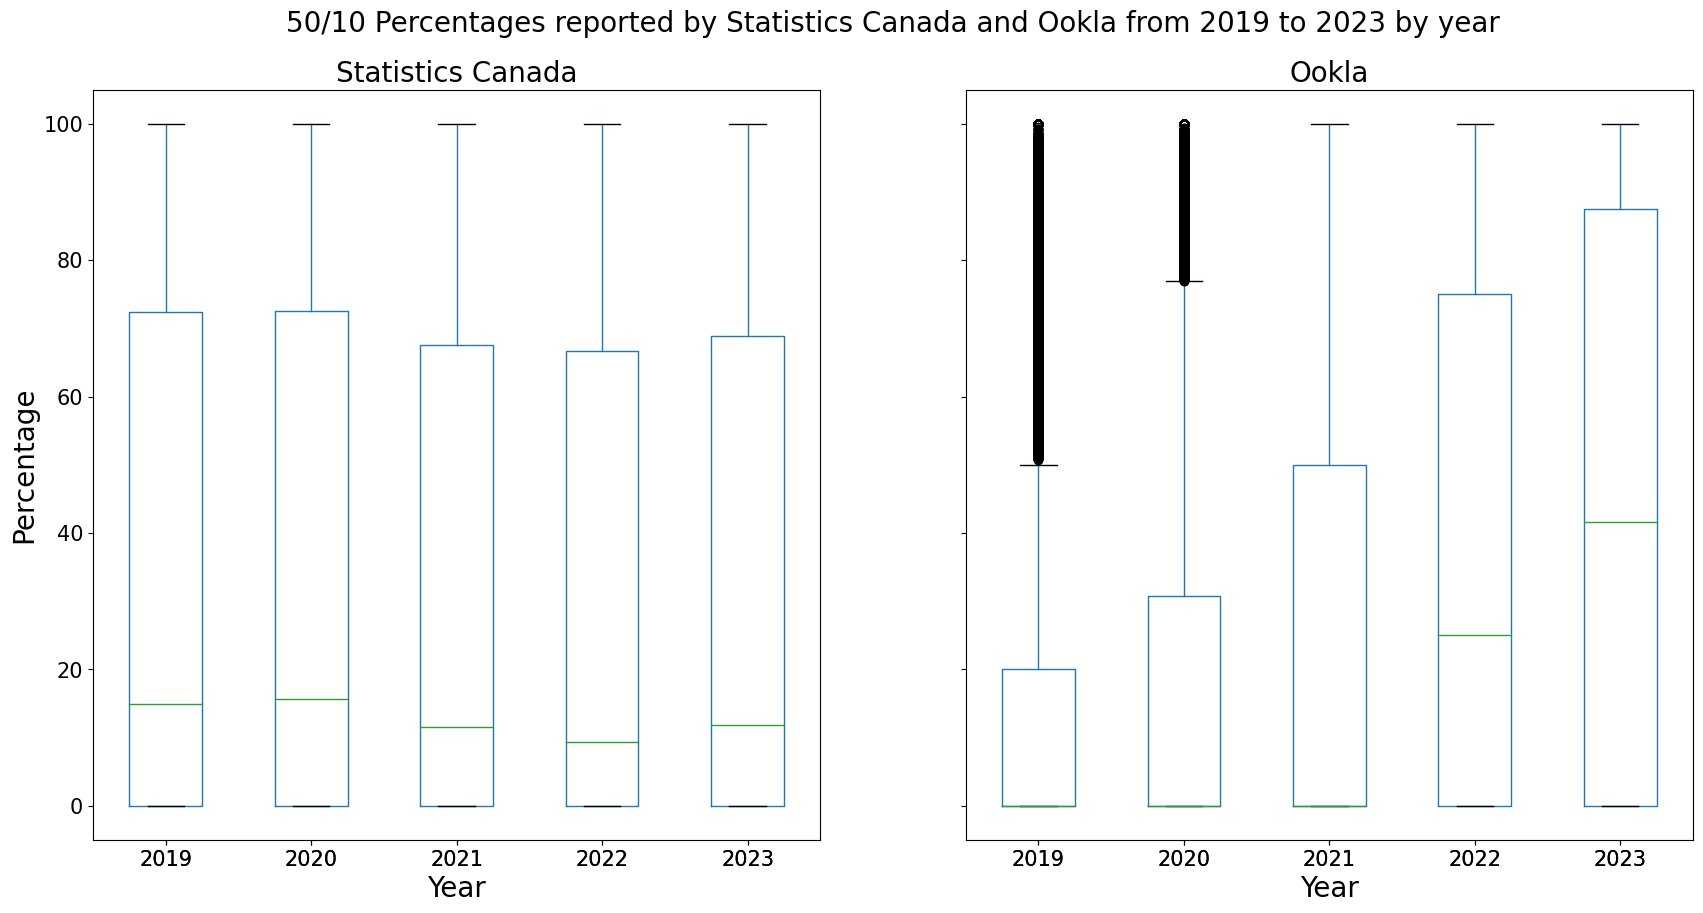

In [12]:
ax = data.boxplot(column=['Pop_Avail_50_10', 
                          'ookla_50_10_percentile'], 
                  by='year',
                  grid=False, 
                  figsize=(20,10),
                  layout=(1,2),
                  sharey=True)

ax[0].set_xlabel('Year', fontsize=20)
ax[1].set_xlabel('Year', fontsize=20)
ax[0].set_ylabel('Percentage', fontsize=20)

ax[0].xaxis.set_tick_params(labelsize=15)
ax[1].xaxis.set_tick_params(labelsize=15)
ax[0].yaxis.set_tick_params(labelsize=15)

ax[0].set_title('Statistics Canada', fontsize=20)
ax[1].set_title('Ookla', fontsize=20)

plt.suptitle('50/10 Percentages reported by Statistics Canada and Ookla ' \
             'from 2019 to 2023 by year',
             fontsize=20);

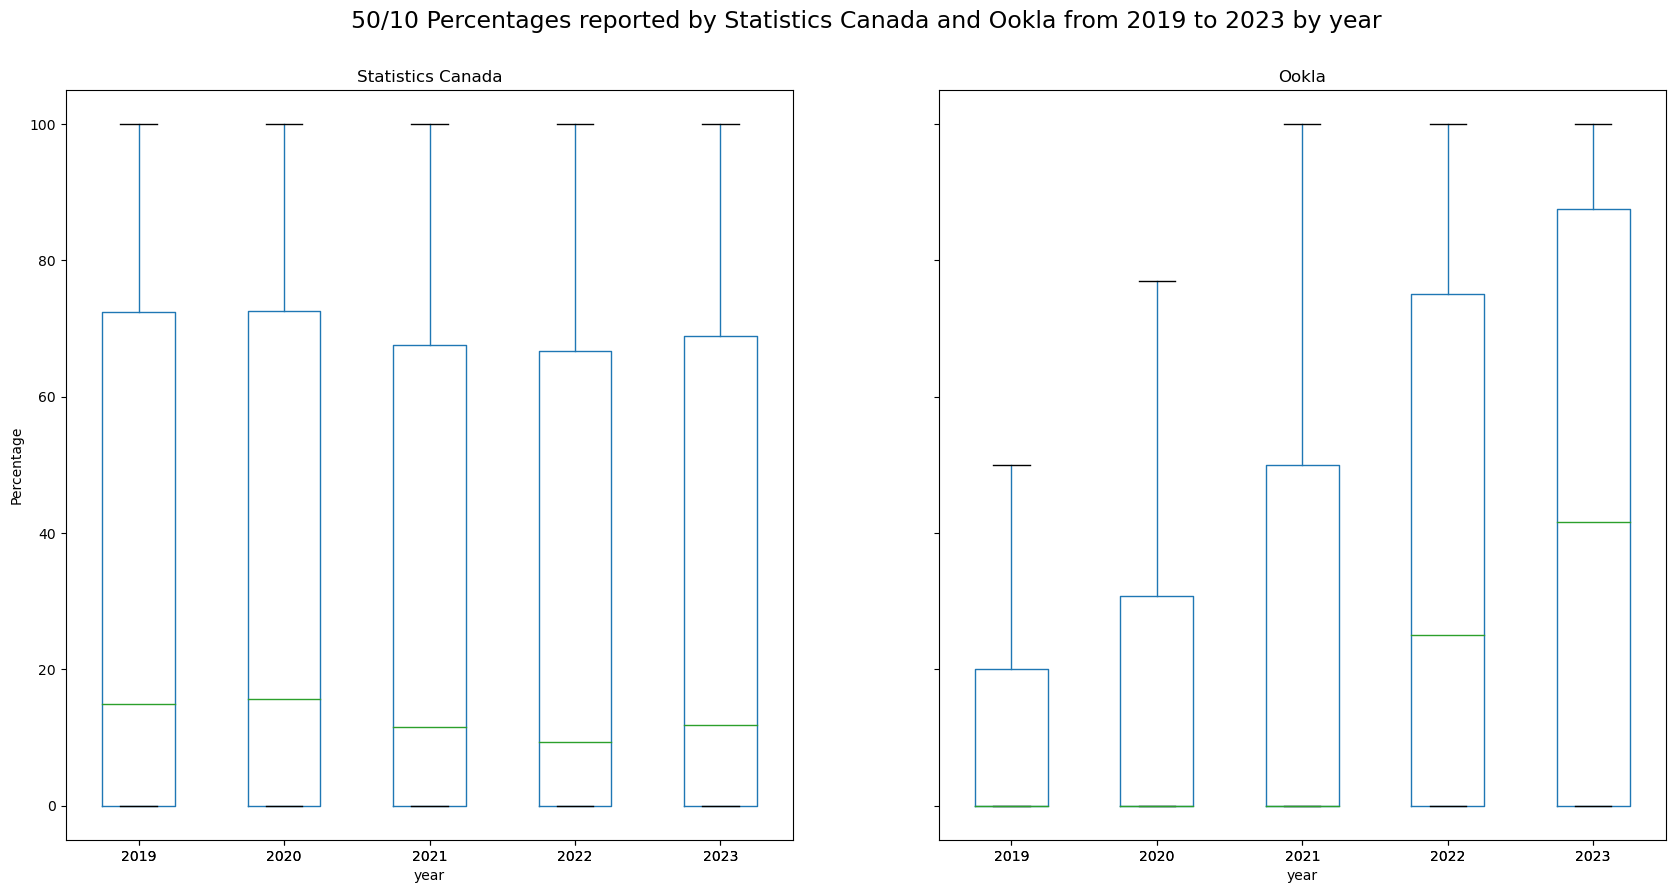

In [13]:
ax = data.boxplot(column=['Pop_Avail_50_10', 
                          'ookla_50_10_percentile'], 
                  by='year',
                  grid=False, 
                  figsize=(20,10),
                  layout=(1,2),
                  showfliers=False,
                  sharey=True)

ax[0].set_ylabel('Percentage')
ax[0].set_title('Statistics Canada')
ax[1].set_title('Ookla')

plt.suptitle('50/10 Percentages reported by Statistics Canada and Ookla ' \
             'from 2019 to 2023 by year',
             fontsize=17);

#### Testing and internet speeds

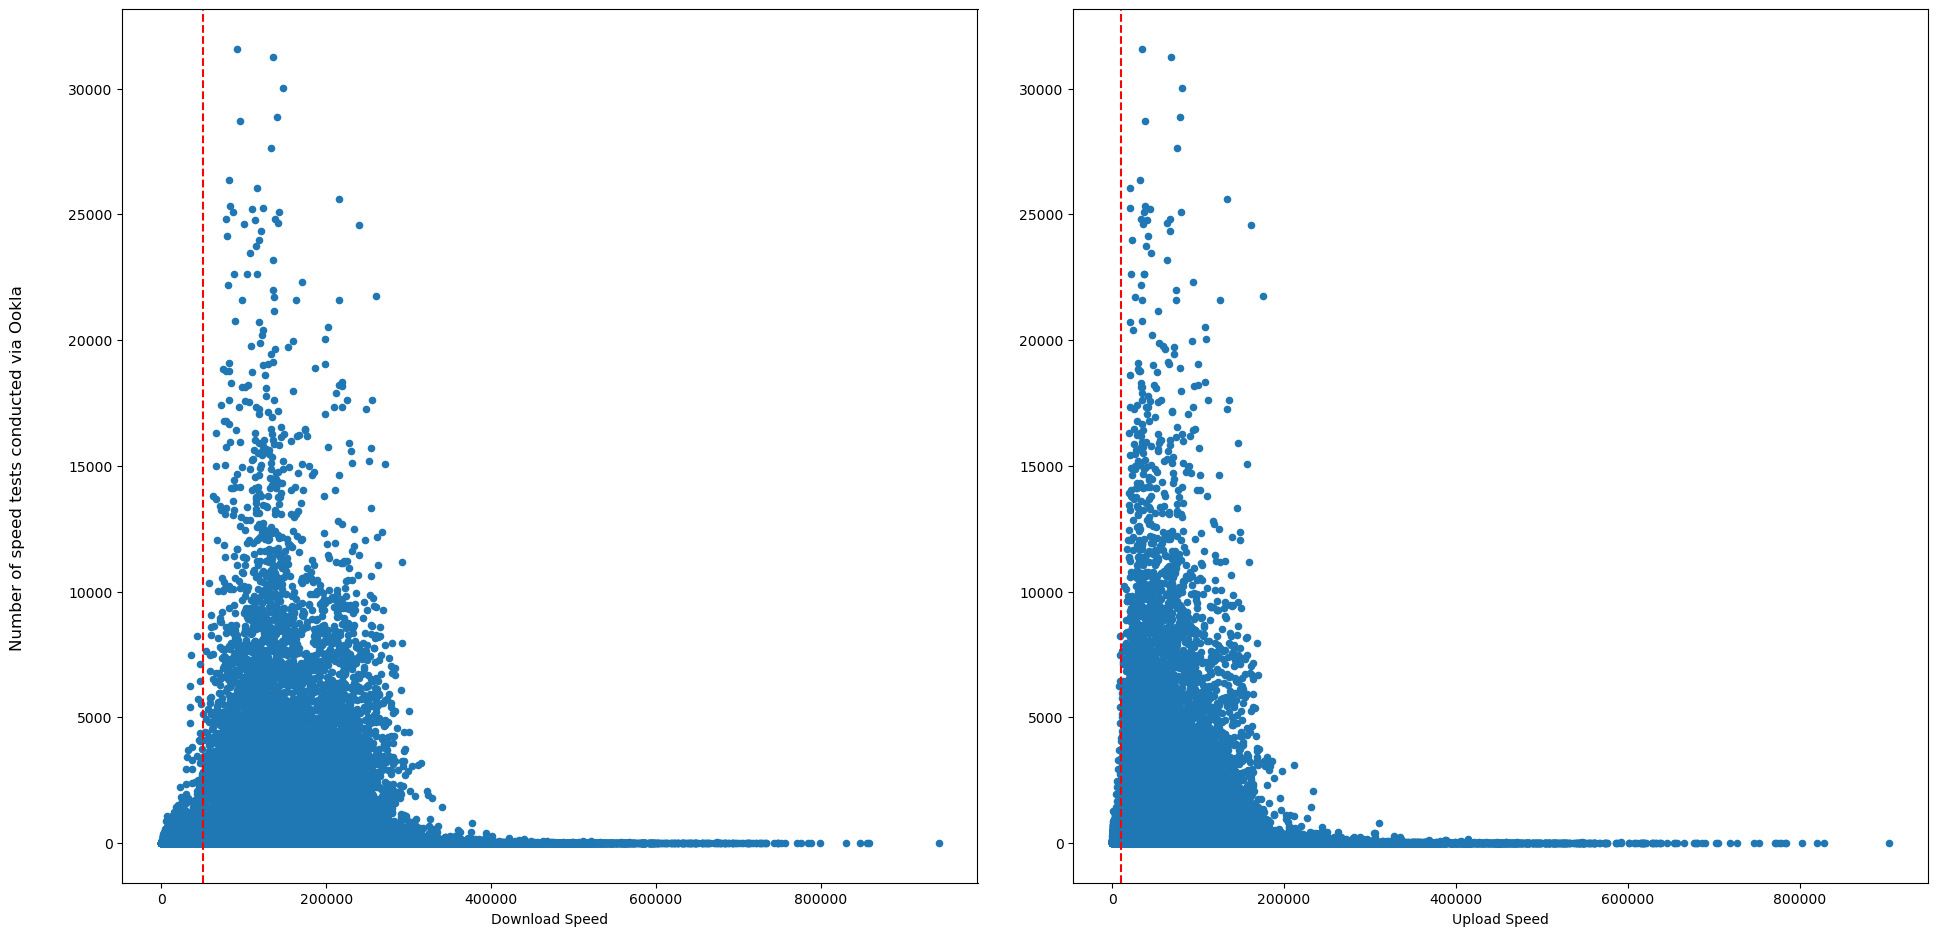

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))

data.plot.scatter('avg_d_kbps', 'tests', ax=axs[0])
data.plot.scatter('avg_u_kbps', 'tests', ax=axs[1])

axs[0].axvline(50000, color='r', ls='--')
axs[1].axvline(10000, color='r', ls='--')

axs[0].set_xlabel('Download Speed')
axs[1].set_xlabel('Upload Speed')
axs[0].set_ylabel('')
axs[1].set_ylabel('')

fig.supylabel('Number of speed tests conducted via Ookla')
#fig.suptitle('Distribution of average internet speeds across ' \
#             'Canada over the last four years',
#             fontsize=25)
fig.tight_layout(pad=3);

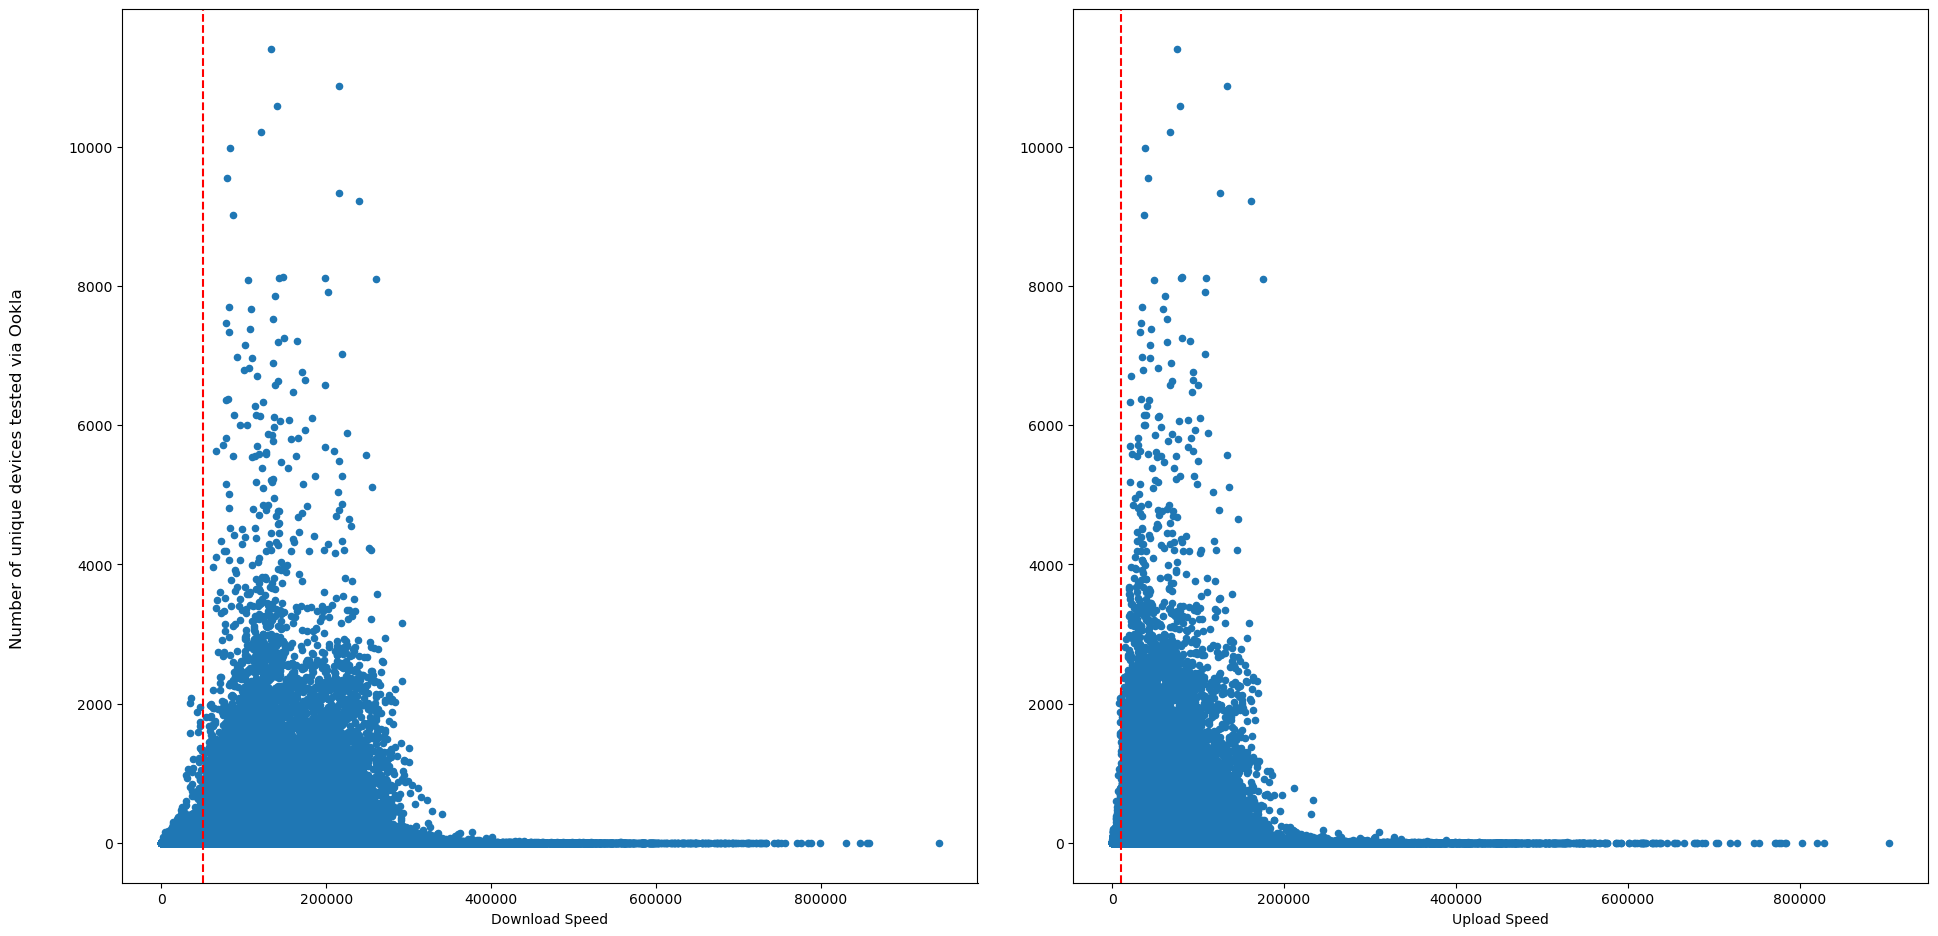

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))

data.plot.scatter('avg_d_kbps', 'unique_devices', ax=axs[0])
data.plot.scatter('avg_u_kbps', 'unique_devices', ax=axs[1])

axs[0].axvline(50000, color='r', ls='--')
axs[1].axvline(10000, color='r', ls='--')

axs[0].set_xlabel('Download Speed')
axs[1].set_xlabel('Upload Speed')
axs[0].set_ylabel('')
axs[1].set_ylabel('')

fig.supylabel('Number of unique devices tested via Ookla')

fig.tight_layout(pad=3);

In [16]:
data['test_frequency'] = data['tests']/data['unique_devices']

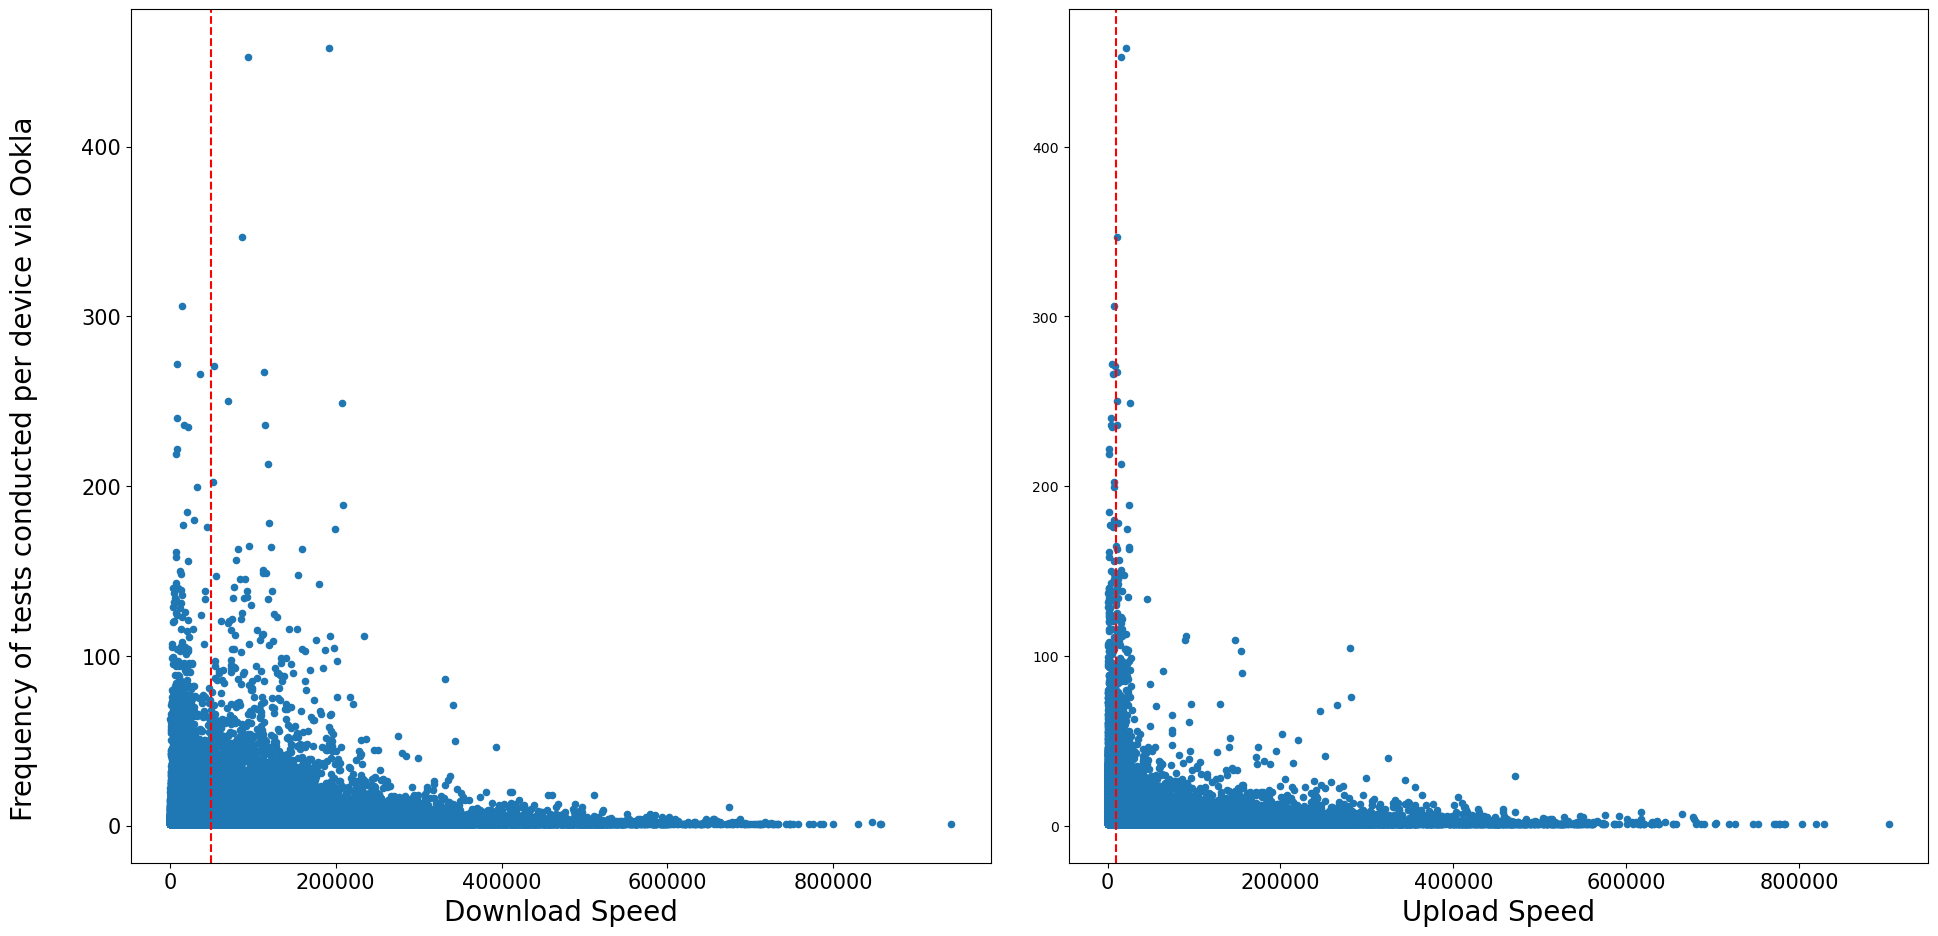

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))

data.plot.scatter('avg_d_kbps', 'test_frequency', ax=axs[0])
data.plot.scatter('avg_u_kbps', 'test_frequency', ax=axs[1])

axs[0].axvline(50000, color='r', ls='--')
axs[1].axvline(10000, color='r', ls='--')

axs[0].set_xlabel('Download Speed', fontsize=20)
axs[1].set_xlabel('Upload Speed', fontsize=20)
axs[0].set_ylabel('')
axs[1].set_ylabel('')

axs[0].xaxis.set_tick_params(labelsize=15)
axs[1].xaxis.set_tick_params(labelsize=15)
axs[0].yaxis.set_tick_params(labelsize=15)

ax[0].set_title('Statistics Canada', fontsize=20)
ax[1].set_title('Ookla', fontsize=20)
fig.supylabel('Frequency of tests conducted per device via Ookla', fontsize=20)

#fig.suptitle('Distribution of average internet speeds across ' \
#             'Canada over the last four years',
#             fontsize=25)
fig.tight_layout(pad=3);

#### Correlation maps

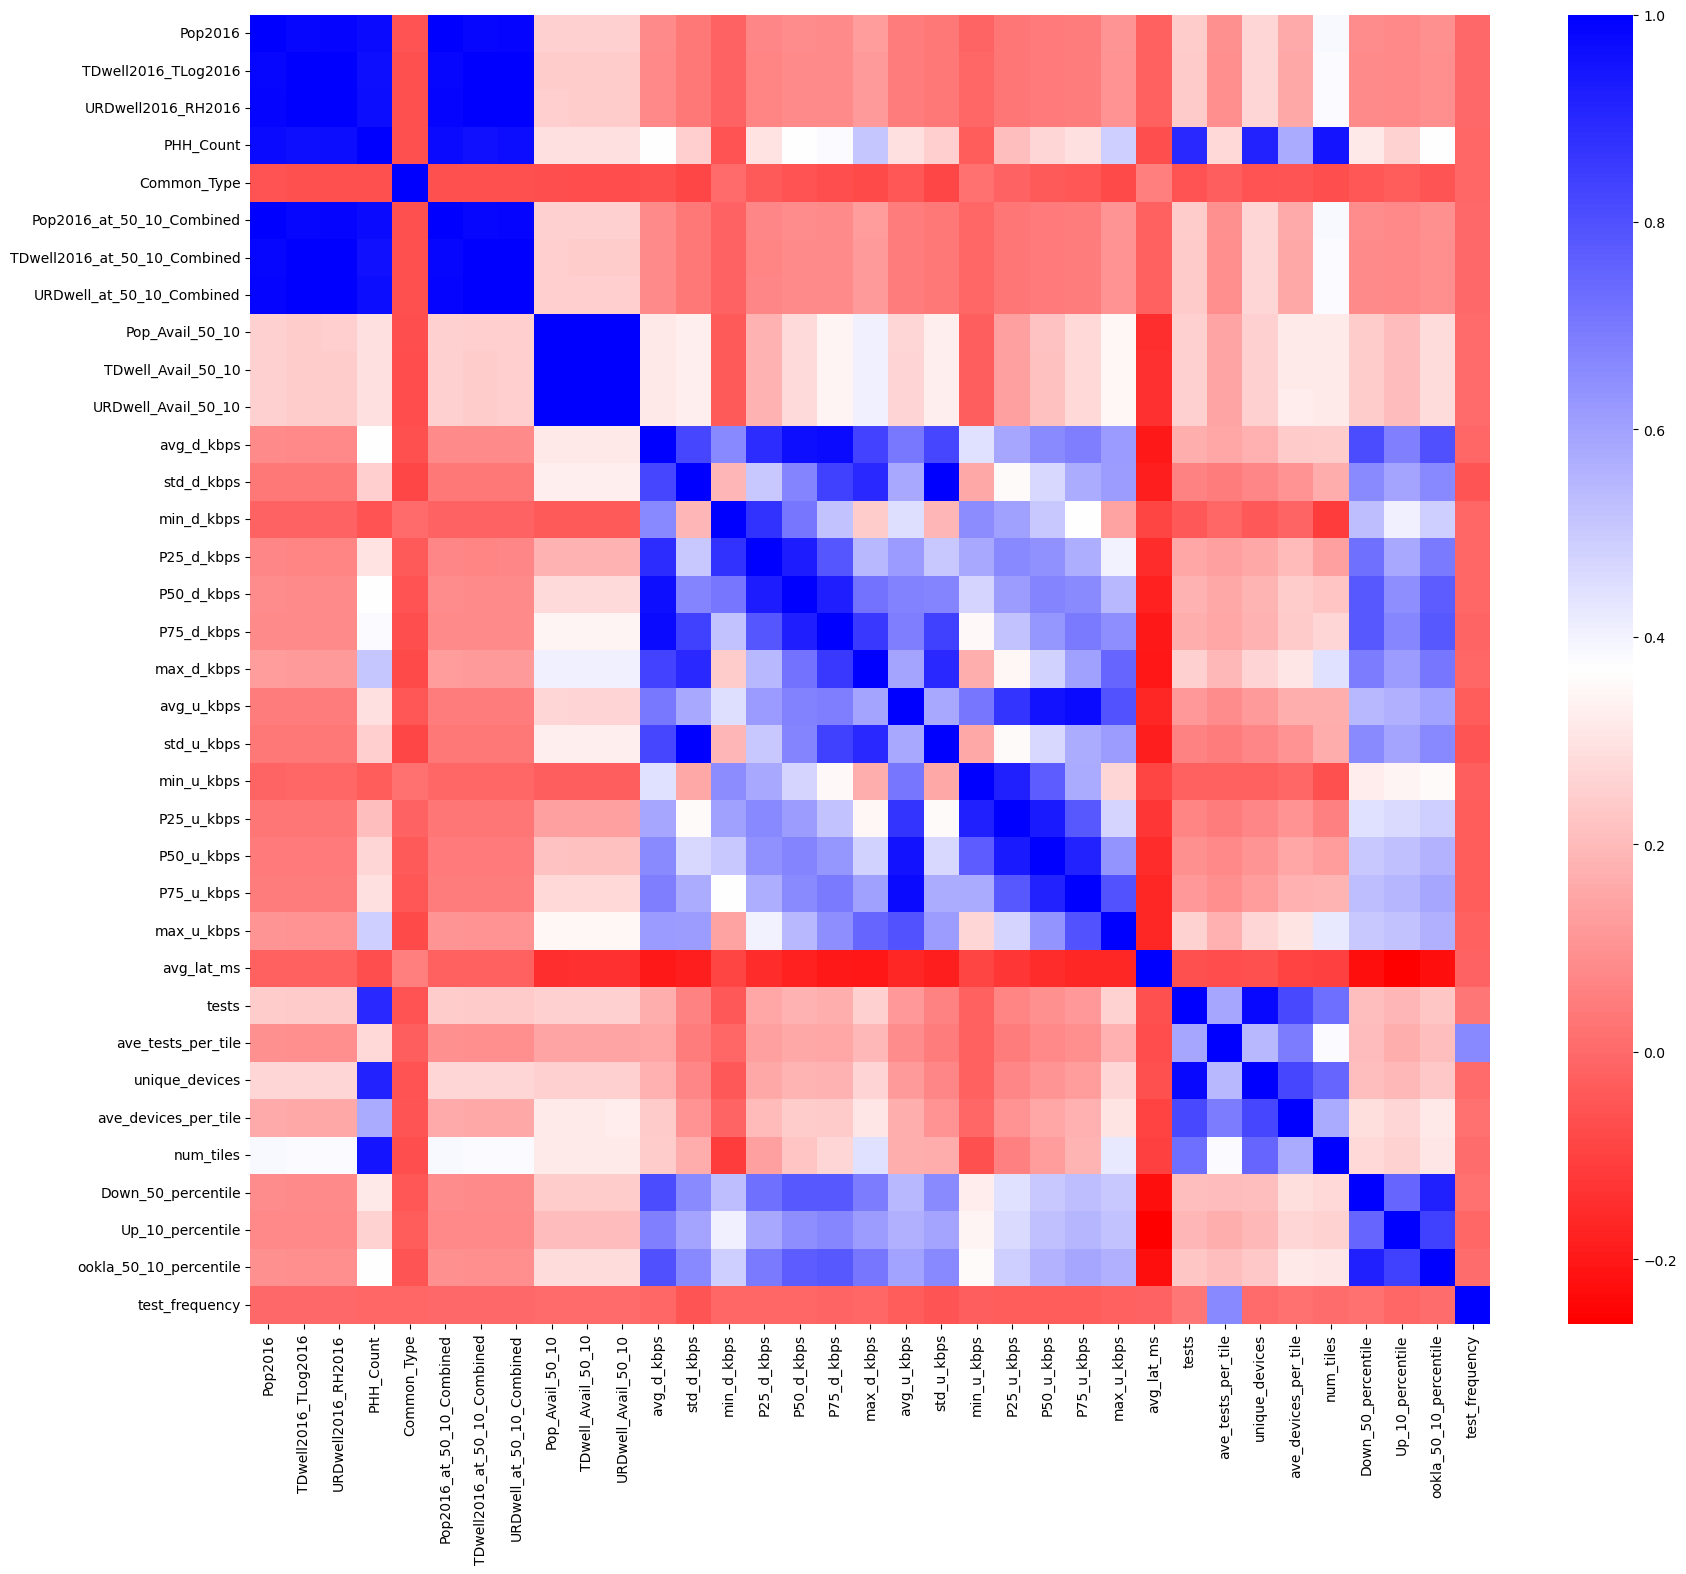

In [18]:
corr = data.corr(numeric_only=True)

# plotting the heatmap
plt.figure(figsize=(20,17))
sns.heatmap(corr, cmap='bwr_r')
plt.show()

In [19]:
# correlation to the average internet speeds
corr2 = corr[['avg_d_kbps', 
              'avg_u_kbps']].drop(['avg_d_kbps', 
                                   'avg_u_kbps'], axis=0).reset_index()
corr2.head()

,index,avg_d_kbps,avg_u_kbps
0,Pop2016,0.081036,0.045768
1,TDwell2016_TLog2016,0.077107,0.043997
2,URDwell2016_RH2016,0.078189,0.044452
3,PHH_Count,0.370066,0.294551
4,Common_Type,-0.061706,-0.045443


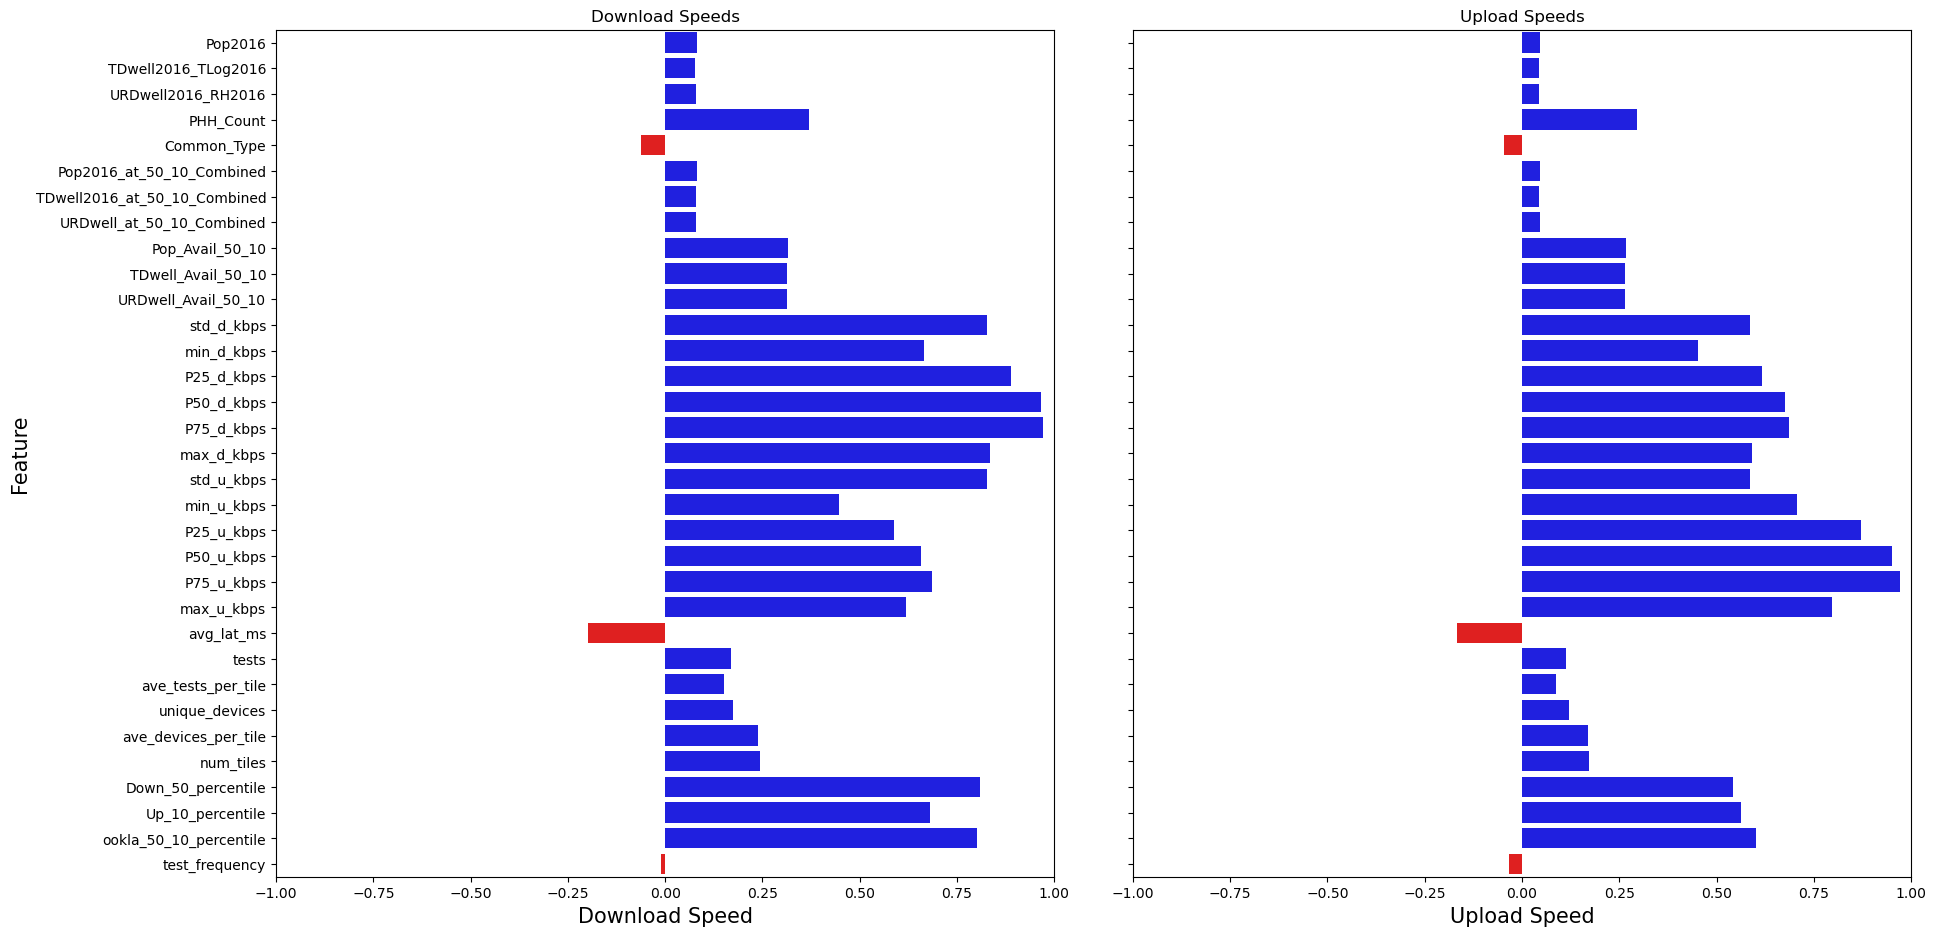

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))
sns.barplot(data=corr2,x=corr2['avg_d_kbps'],y=corr2['index'],ax=axs[0],
            palette=corr2['avg_d_kbps'].apply(lambda x: 'b' if x>0 else 'r'),
            orient='h')

sns.barplot(data=corr2,x=corr2['avg_u_kbps'],y=corr2['index'],ax=axs[1],
            palette=corr2['avg_u_kbps'].apply(lambda x: 'b' if x>0 else 'r'),
            orient='h')

axs[0].set(xlim=(-1, 1), ylabel='variable', 
           title='Download Speeds')
axs[1].set(xlim=(-1, 1), ylabel=None, 
           yticklabels=[], title='Upload Speeds')

axs[0].set_xlabel('Download Speed', fontsize=15)
axs[1].set_xlabel('Upload Speed', fontsize=15)
axs[0].set_ylabel('Feature', fontsize=15)

fig.tight_layout(pad=3);

**Summary** <br>
Overall, our EDA reveals high correlation between numberical variables studies and internet speeds. Particulary, `PHH_Count`, `Common_Tpye`, `Pop_Avail_50_10`, `min_d_kbps`, `max_d_kbps`, `std_d_kbps`, `min_u_kbps`, `max_u_kbps`, `std_u_kbps`, and `test_frequency` are reccommeded features for ML modeling

### Improving the linear model

In [21]:
# categorizing the variables
key = 'HEXUID_PCPUID'
geometry = 'geometry'

id_and_names = ['PCPUID', 'PCNAME']

categorical_vars = ['PRCODE', 'PCCLASS', 'year', 'quarter']

numerical_vars = ['PHH_Count', 'Common_Type', 
                  'std_d_kbps', 'min_d_kbps', 
                  'max_d_kbps', 'std_u_kbps', 
                  'min_u_kbps', 'max_u_kbps', 
                  'test_frequency', 'Pop_Avail_50_10']

other_vars = ['Pop2016','TDwell2016_TLog2016', 
              'URDwell2016_RH2016',
              'Pop2016_at_50_10_Combined', 
              'TDwell2016_at_50_10_Combined', 
              'URDwell_at_50_10_Combined', 
              'TDwell_Avail_50_10',
              'URDwell_Avail_50_10',
              'P25_d_kbps', 'P50_d_kbps', 'P75_d_kbps',
              'P25_u_kbps', 'P50_u_kbps', 'P75_u_kbps',
              'tests', 'ave_tests_per_tile',
              'unique_devices', 'ave_devices_per_tile', 
              'num_tiles', 'Down_50_percentile', 
              'Up_10_percentile', 'connections']

target_vars = ['avg_d_kbps', 'avg_u_kbps']

In [22]:
ml_vars = [key] + categorical_vars + numerical_vars + target_vars
ml_data = data.loc[:,ml_vars].set_index('HEXUID_PCPUID')
ml_data.head()

,PRCODE,PCCLASS,year,quarter,PHH_Count,Common_Type,std_d_kbps,min_d_kbps,max_d_kbps,std_u_kbps,min_u_kbps,max_u_kbps,test_frequency,Pop_Avail_50_10,avg_d_kbps,avg_u_kbps
HEXUID_PCPUID,,,,,,,,,,,,,,,,
NL47580528-100792,NL,4,2019,1,NaN,NaN,73606.566105,1778.0,323175.0,73606.566105,4936.0,279398.0,2.621359,NaN,102684.125000,71012.583333
NL47580529-100792,NL,4,2019,1,NaN,NaN,102702.357769,5245.0,373129.0,102702.357769,10411.0,323102.0,3.200000,NaN,133066.516129,95761.903226
NL47430528-100792,NL,4,2019,1,NaN,NaN,NaN,37021.0,37021.0,NaN,15747.0,15747.0,2.000000,NaN,37021.000000,15747.000000
NL47510528-100792,NL,4,2019,1,NaN,NaN,57255.122716,1925.0,331983.0,57255.122716,1210.0,175058.0,3.289720,NaN,99649.597701,61114.482759
NL47510529-100792,NL,4,2019,1,NaN,NaN,79164.061679,802.0,329793.0,79164.061679,745.0,264576.0,2.890110,NaN,108912.500000,81885.826087


In [23]:
# repacing Nan values in categorical variables with cat=0 
# & replacing Nan values in numerical variables with the median

ml_data['PCCLASS'].fillna(value='0', inplace =True)
ml_data['PHH_Count'].fillna(value='0', inplace =True)
ml_data['Common_Type'].fillna(value='0', inplace =True)

ml_data['std_d_kbps'].fillna(value=ml_data['std_d_kbps'].median(), inplace =True)
ml_data['std_u_kbps'].fillna(value=ml_data['std_u_kbps'].median(), inplace =True)
ml_data['Pop_Avail_50_10'].fillna(value=ml_data['Pop_Avail_50_10'].median(), inplace =True)

ml_data.isna().sum()

PRCODE             0
PCCLASS            0
year               0
quarter            0
PHH_Count          0
Common_Type        0
std_d_kbps         0
min_d_kbps         0
max_d_kbps         0
std_u_kbps         0
min_u_kbps         0
max_u_kbps         0
test_frequency     0
Pop_Avail_50_10    0
avg_d_kbps         0
avg_u_kbps         0
dtype: int64

In [24]:
# droppping Nan values for regression modeling
ml_data.dropna(inplace=True)
ml_data.shape

(385775, 16)

In [25]:
# create a standard train/test where down and/or up speeds are 
# the target/predicted continuous variable.

X_train, X_test, \
down_train, down_test, \
up_train, up_test = model_selection.train_test_split(
    ml_data, ml_data['avg_d_kbps'], ml_data['avg_u_kbps']
)

In [26]:
# normalize the numerical Data and OneHot encode the categorical vars.
colTransformer = compose.ColumnTransformer(
    [(f"{cat}",preprocessing.OneHotEncoder(),[cat]) for cat in categorical_vars] \
    + [(f"{num}", preprocessing.StandardScaler(), [num]) for num in numerical_vars] 
    + [(f"{y}_stdscaler", preprocessing.StandardScaler(), [y]) for y in target_vars]
)

# setup a regressor for predicting down/up speeds.
regressor = linear_model.RidgeCV()

# combine above in a reuseable pipeline object
pipe = pipeline.Pipeline([
    ('preprocess',colTransformer),
    ('regressor', regressor)
])

In [27]:
#train the downloads model
down_ml = pipe.fit(X_train, down_train)

In [28]:
# how did it do on the training set
# speeds are in kbps
{"Mean Absolute Error":metrics.mean_absolute_error(pipe.predict(X_train), down_train),
"Median Absolute Error":metrics.median_absolute_error(pipe.predict(X_train), down_train),
"Mean Absolute Percentage Error":metrics.mean_absolute_percentage_error(pipe.predict(X_train), down_train)
}

{'Mean Absolute Error': 0.06757096499117725,
 'Median Absolute Error': 0.03808388896868564,
 'Mean Absolute Percentage Error': 4.7524720788598405e-06}

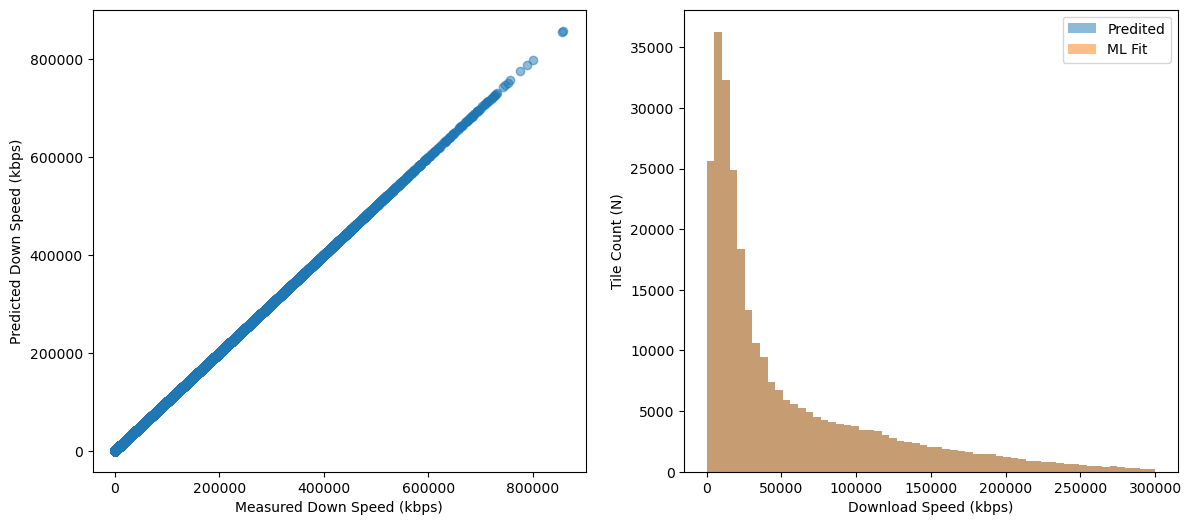

In [29]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
axs[0].scatter(down_train, pipe.predict(X_train), alpha=0.5);
axs[0].set(xlabel="Measured Down Speed (kbps)", ylabel="Predicted Down Speed (kbps)");

bins = np.linspace(0,300000,60)
axs[1].hist(down_train,alpha=0.5, bins=bins,label='Predited')
axs[1].hist(pipe.predict(X_train),alpha=0.5, bins=bins,label='ML Fit');
axs[1].legend()
axs[1].set(xlabel='Download Speed (kbps)', ylabel='Tile Count (N)');

In [30]:
#train the downloads model
up_ml = pipe.fit(X_train, up_train)

In [31]:
# how did it do on the training set
# speeds are in kbps
{"Mean Absolute Error":metrics.mean_absolute_error(pipe.predict(X_train), up_train),
"Median Absolute Error":metrics.median_absolute_error(pipe.predict(X_train), up_train),
"Mean Absolute Percentage Error":metrics.mean_absolute_percentage_error(pipe.predict(X_train), up_train)
}

{'Mean Absolute Error': 0.026943962159876544,
 'Median Absolute Error': 0.00908900422291481,
 'Mean Absolute Percentage Error': 3.7657819066372506e-06}

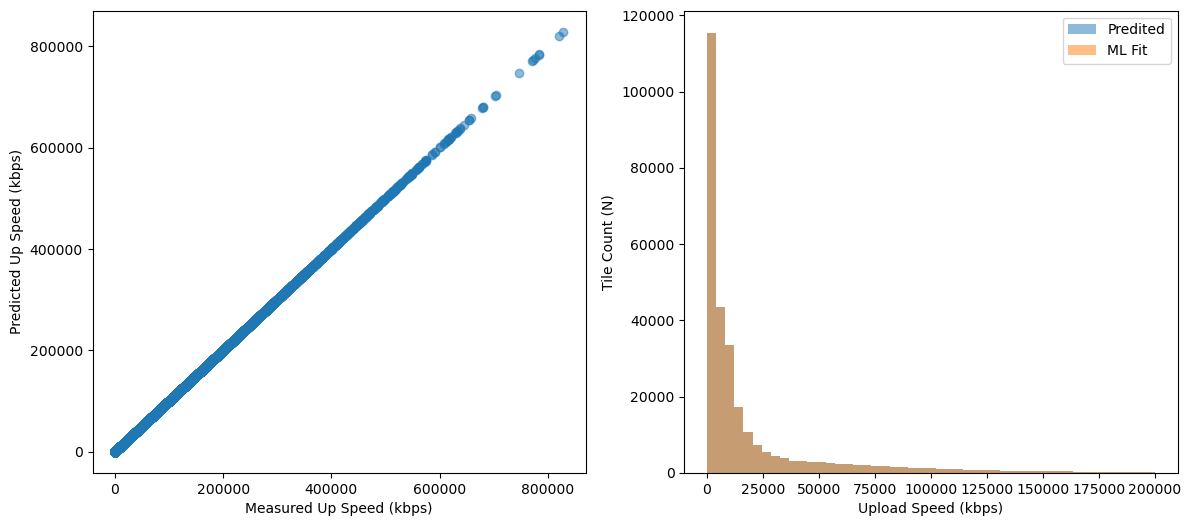

In [32]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
axs[0].scatter(up_train, pipe.predict(X_train), alpha=0.5);
axs[0].set(xlabel="Measured Up Speed (kbps)", ylabel="Predicted Up Speed (kbps)");

bins = np.linspace(0,200000,50)
axs[1].hist(up_train,alpha=0.5, bins=bins,label='Predited')
axs[1].hist(pipe.predict(X_train),alpha=0.5, bins=bins,label='ML Fit');
axs[1].legend()
axs[1].set(xlabel='Upload Speed (kbps)', ylabel='Tile Count (N)');

In [33]:
# saving pandas df so its easier to load in streamlit app
df = pd.DataFrame(data.drop(columns='geometry'))
df.to_csv(data_dir / (data_name+".csv"))